


<h1> ML Project--Prudential Life Insurance Assessment </h1>
Developed by Huijin Cao
<br></br>

## Context Information

### Dataset Overview

The dataset contains over a hundred variables describing the attributes of life insurance applicants. The goal is to predict the **"Response"** variable for each ID in the test set. 

- **"Response"** is an ordinal measure of risk with 8 levels.


# Table of Contents
- [Chapter 1: Data Import](#Chapter-1:-Data-Import)
- [Chapter 2: Exploratory Data Analysis](#Chapter-2:-Exploratory-Data-Analysis)
  - [2.1 Exploring and visualizing missing data](#2.1-Exploring-and-visualizing-missing-data)
  - [2.2 Exploring Single Categorical Features](#2.2-Exploring-Single-Categorical-Features)
  - [2.3 Exploring Single Numerical Features](#2.3-Exploring-Single-Numerical-Features)
  - [2.4 Exploring Relationship between Variables](#2.4-Exploring-Relationship-between-Variables)
    - [2.4.1 Numerical to numerical relationships (the relationship between numerical features)](#2.4.1-Numerical-to-numerical-relationships-(the-relationship-between-numerical-features))
    - [2.4.2 Categorical to numerical relationships (the relationship between categorical label and each of numerical features)](#2.4.2-Categorical-to-numerical-relationships-(the-relationship-between-categorical-label-and-each-of-numerical-features))
    - [2.4.3 Categorical to categorical relationships (the relationship between categorical label and each of categorical features)](#2.4.3-Categorical-to-categorical-relationships-(the-relationship-between-categorical-label-and-each-of-categorical-features))
- [Chapter 3: Feature Engineering](#Chapter-3:-Feature-Engineering)
- [Chapter 4:  Model Tuning](#Chapter-4:--Model-Tuning)
  - [4.1 XGBoost  Model Tuning without Data Preparation](#4.1-XGBoost--Model-Tuning-without-Data-Preparation)
  - [4.2 LightGBM  Model Tuning without Data Preparation](#4.2-LightGBM--Model-Tuning-without-Data-Preparation)
  - [4.3 stacking XGBoost and LightGBM](#4.3-stacking-XGBoost-and-LightGBM)
  - [4.4 Other ML Models Tuning with Data Preparation](#4.4-Other-ML-Models-Tuning-with-Data-Preparation)
    - [4.4.1 LogisticRegression, DecisionTree, RandomForest Models Tuning](#4.4.1-LogisticRegression,-DecisionTree,-RandomForest-Models-Tuning)
    - [4.4.2 Neural Network](#4.4.2-Neural-Network)
- [Chapter 5: Model Interpretation](#Chapter-5:-Model-Interpretation)
- [Chapter 6: Predict Test Data](#Chapter-6:-Predict-Test-Data)

### Chapter 1: Data Import

In [3]:
import pandas as pd

In [4]:
df_train=pd.read_csv('train.csv',
                                sep=',',
                                index_col='Id'
                                )
X_test=pd.read_csv('test.csv',
                                       sep=',',
                                       index_col='Id'
                                      )

In [5]:
print('df_train.shape:', df_train.shape)
print('X_test.shape:', X_test.shape)

df_train.shape: (59381, 127)
X_test.shape: (19765, 126)


In [6]:
df_train.head()

Product_Info_1 Product_Info_2  Product_Info_3  Product_Info_4  \
Id                                                                  
2                1             D3              10        0.076923   
5                1             A1              26        0.076923   
6                1             E1              26        0.076923   
7                1             D4              10        0.487179   
8                1             D2              26        0.230769   

    Product_Info_5  Product_Info_6  Product_Info_7   Ins_Age        Ht  \
Id                                                                       
2                2               1               1  0.641791  0.581818   
5                2               3               1  0.059701  0.600000   
6                2               3               1  0.029851  0.745455   
7                2               3               1  0.164179  0.672727   
8                2               3               1  0.417910  0.654545   

          Wt  ...  Medical_Keyword_40  Medical_Keyword_41  Medical_Keyword_42  \
Id            ...                                                               
2   0.148536  ...                   0                   0                   0   
5   0.131799  ...                   0                   0                   0   
6   0.288703  ...                   0                   0                   0   
7   0.205021  ...                   0                   0                   0   
8   0.234310  ...                   0                   0                   0   

    Medical_Keyword_43  Medical_Keyword_44  Medical_Keyword_45  \
Id                                                               
2                    0                   0                   0   
5                    0                   0                   0   
6                    0                   0                   0   
7                    0                   0                   0   
8                    0                   0                   0   

    Medical_Keyword_46  Medical_Keyword_47  Medical_Keyword_48  Response  
Id                                                                        
2                    0                   0                   0         8  
5                    0                   0                   0         4  
6                    0                   0                   0         8  
7                    0                   0                   0         8  
8                    0                   0                   0         8  

[5 rows x 127 columns]

In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 59381 entries, 2 to 79146
Columns: 127 entries, Product_Info_1 to Response
dtypes: float64(18), int64(108), object(1)
memory usage: 58.0+ MB


In [8]:
#to double check whether X_test share any index with df_train
any(elem in df_train.index.tolist() for elem in X_test.index.tolist())

False

### Chapter 2: Exploratory Data Analysis

#### 2.1 Exploring and visualizing missing data

In [9]:
# exploring missing data in df_train
ms=df_train.isna().sum() #get the number of missing values in each column
ms_percent=ms/df_train.shape[0] #get the percentage of the missing values in each column
ms_percent[ms_percent>0].sort_values(ascending=False) #return the columns with missing values in descending order

Medical_History_10     0.990620
Medical_History_32     0.981358
Medical_History_24     0.935990
Medical_History_15     0.751015
Family_Hist_5          0.704114
Family_Hist_3          0.576632
Family_Hist_2          0.482579
Insurance_History_5    0.427679
Family_Hist_4          0.323066
Employment_Info_6      0.182786
Medical_History_1      0.149694
Employment_Info_4      0.114161
Employment_Info_1      0.000320
dtype: float64

###### Analysis: 
- Medical_History_10,Medical_History_32,Medical_History_24,Medical_History_15, Family_Hist_5 have over 70% missing values, making them potential candidates for removal.
- Family_Hist_3,Family_Hist_2, Insurance_History_5,Family_Hist_4 have moderate number of missing values. Further analysis is needed.
-  Employment_Info_6,Medical_History_1,Employment_Info_4,Employment_Info_1 have no more than 20% missing values. These could be considered for imputation to address the missing data.

<Axes: >

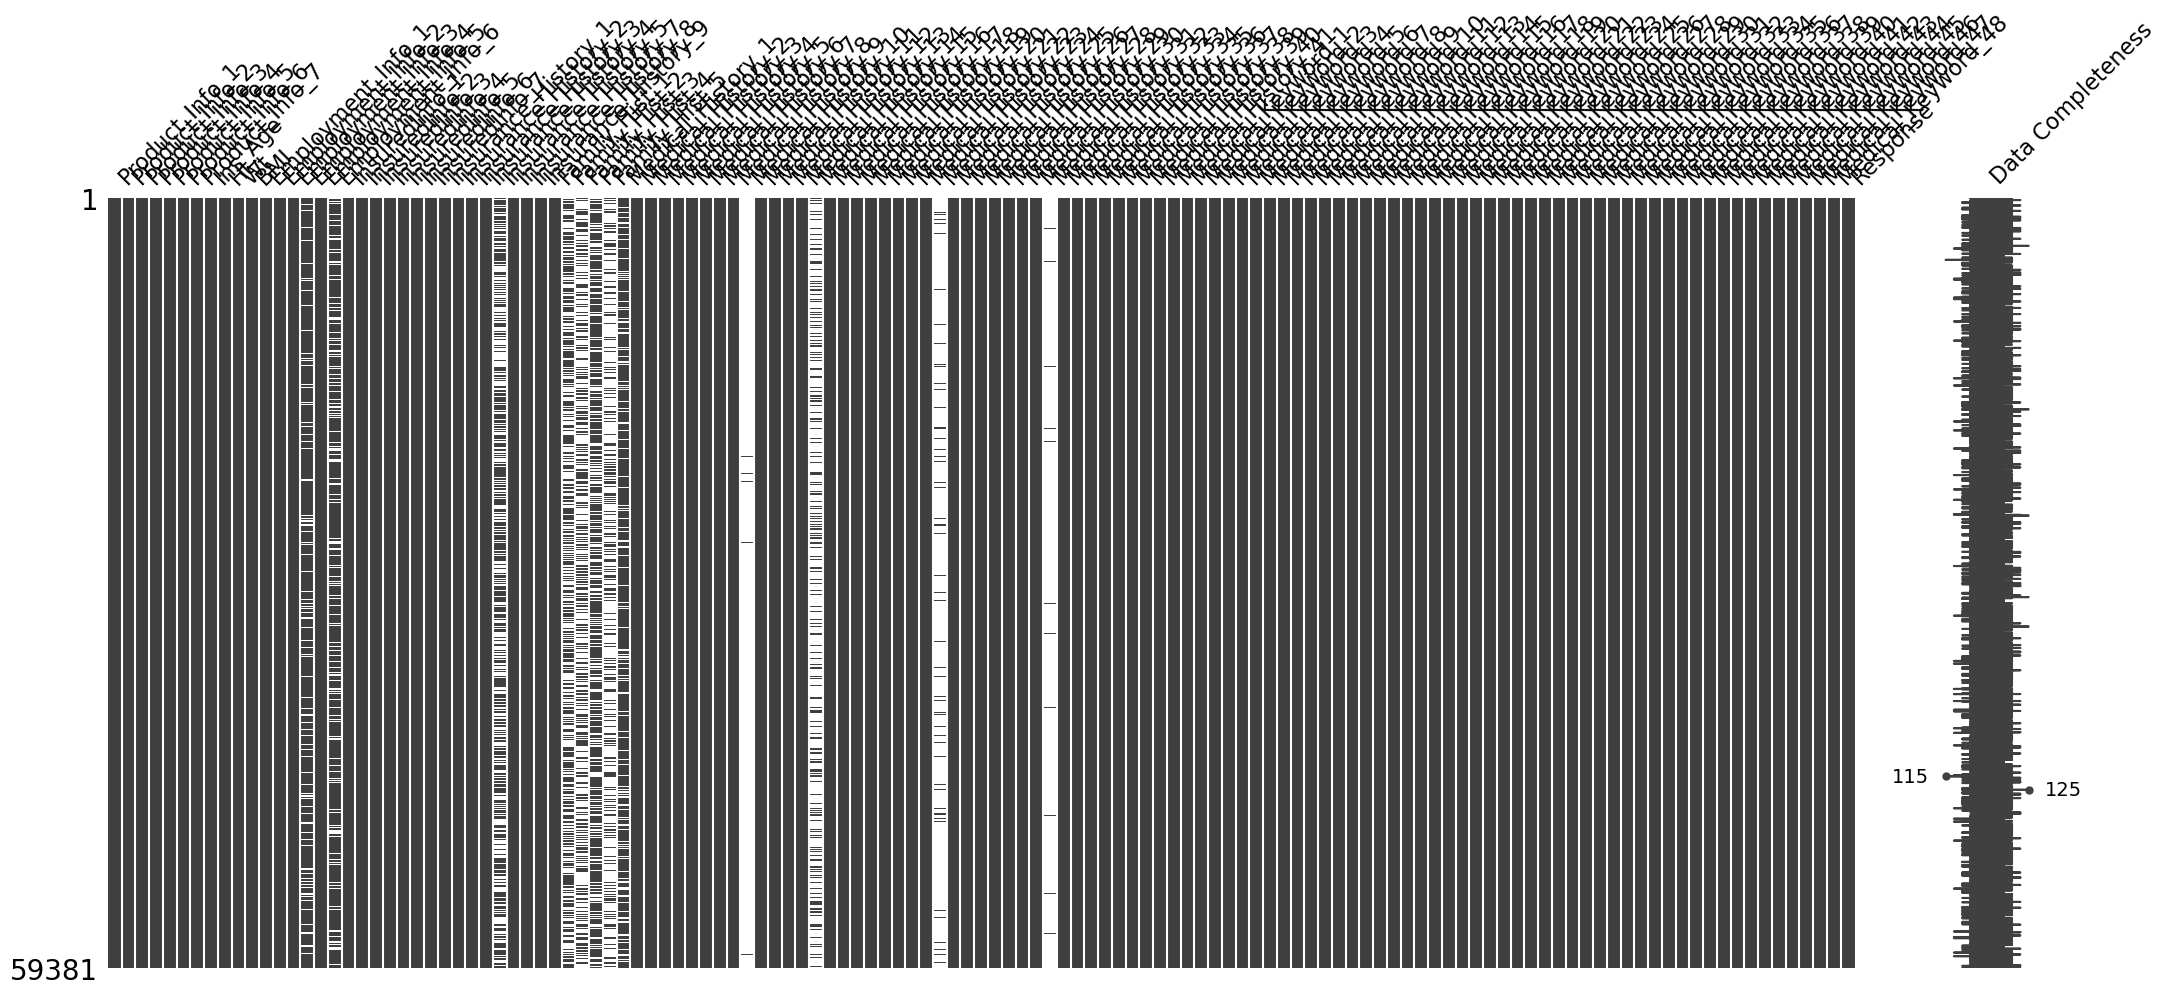

In [10]:
# visualizing missing data
!pip install missingno
import missingno as msno
#to display all null values existing in each column by white color, labels here represent column names:
msno.matrix(df_train, labels=True) 

##### From visualization, it seems the missing values from different columns are not correlated with each other.

#### 2.2 Exploring Single Categorical Features

In [11]:
#extract all categorical variables (including the target)
df_train_cat = df_train[['Product_Info_1', 'Product_Info_2', 'Product_Info_3', 'Product_Info_5', 'Product_Info_6', 
                                                      'Product_Info_7',
                                                       'Employment_Info_2', 'Employment_Info_3', 'Employment_Info_5', 
                                                       'InsuredInfo_1', 'InsuredInfo_2', 'InsuredInfo_3', 'InsuredInfo_4', 'InsuredInfo_5', 
                                                       'InsuredInfo_6', 'InsuredInfo_7','Insurance_History_1', 'Insurance_History_2', 
                                                       'Insurance_History_3', 'Insurance_History_4', 'Insurance_History_7', 'Insurance_History_8', 
                                                       'Insurance_History_9', 
                                                       'Family_Hist_1', 
                                                       'Medical_History_2', 'Medical_History_3', 'Medical_History_4', 'Medical_History_5', 
                                                       'Medical_History_6', 'Medical_History_7', 'Medical_History_8', 'Medical_History_9', 
                                                       'Medical_History_11', 'Medical_History_12', 'Medical_History_13', 'Medical_History_14', 
                                                       'Medical_History_16', 'Medical_History_17', 'Medical_History_18', 'Medical_History_19', 
                                                       'Medical_History_20', 'Medical_History_21', 'Medical_History_22', 'Medical_History_23', 
                                                       'Medical_History_25', 'Medical_History_26', 'Medical_History_27', 'Medical_History_28', 
                                                       'Medical_History_29', 'Medical_History_30', 'Medical_History_31', 'Medical_History_33', 
                                                       'Medical_History_34', 'Medical_History_35', 'Medical_History_36', 'Medical_History_37', 
                                                       'Medical_History_38', 'Medical_History_39', 'Medical_History_40', 'Medical_History_41',
                                                       'Response']]


In [12]:
df_train_cat.shape

(59381, 61)

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

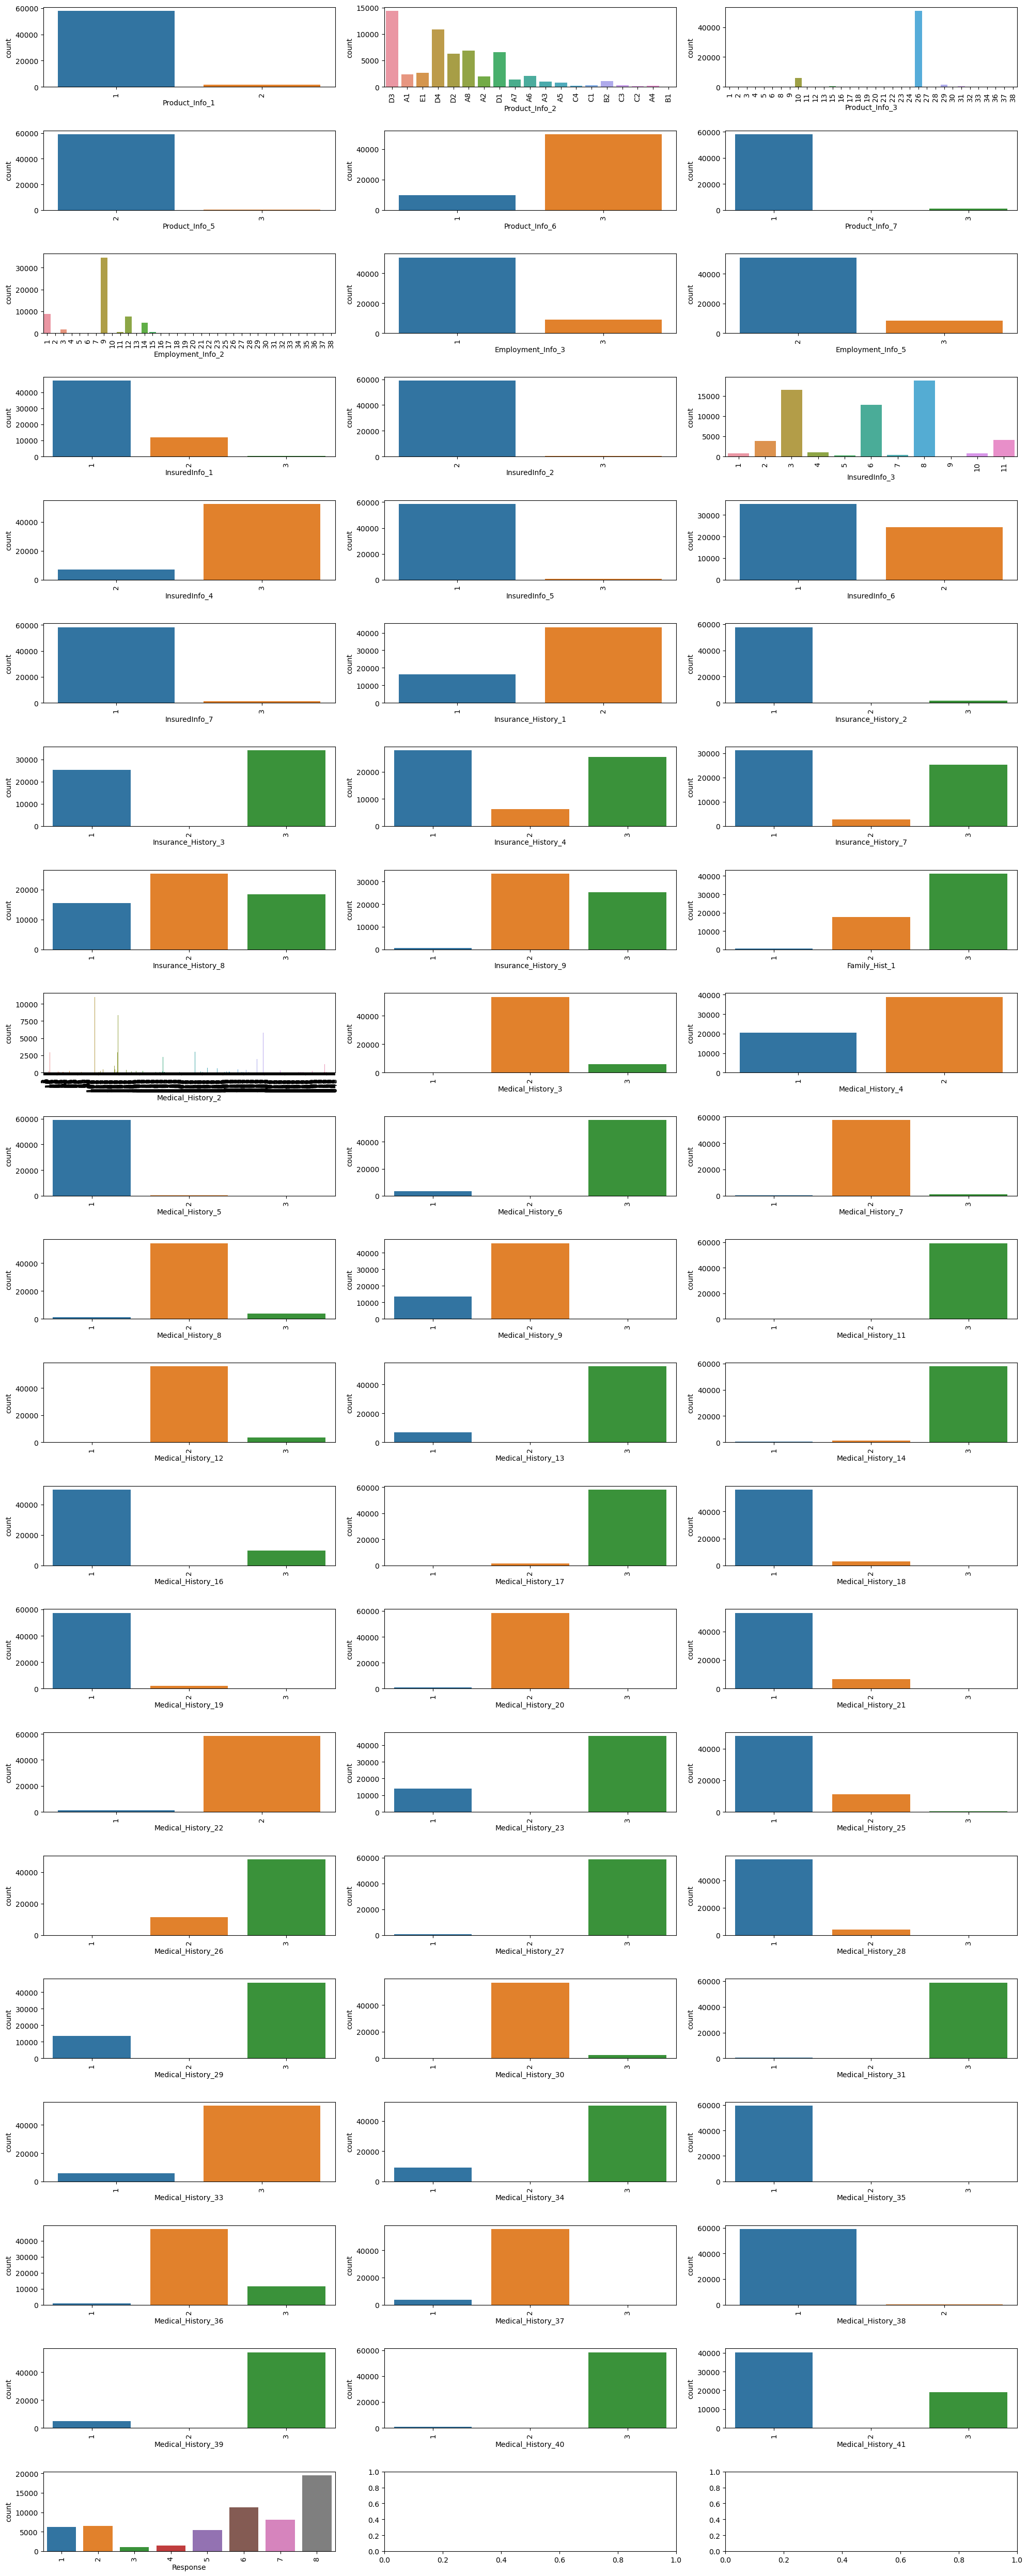

In [14]:
#Categorical columns count plot visualization:

num_cat = df_train_cat.shape[1] #get the number of categorical variables in total
numcols = 3 # arrange subplots by 3 columns
numrows = int(np.ceil(num_cat/ numcols)) #calculate the rows of subplots 
fig, axes = plt.subplots(numrows, numcols, figsize=(20, 50))
for i in range(num_cat):
    row_axis = int(np.floor(i / numcols))
    col_axis = np.remainder(i, numcols) 
    ax = axes[row_axis, col_axis] 
    sns.countplot(ax=ax, data=df_train_cat, x=df_train_cat.iloc[:, i])
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90) 
fig.tight_layout(h_pad=2) # use the tight_layout for avoid ax overlapping


##### Analysis:
- It seems all the categorical variables are imbalanced except InsuredInfo_6, Medical_History_4, Insurance_History_3, and Insurance_History_8. These imbalanced categorical features could be considered for target encoding or frequency encoding to better capture their relationship with the target variable.
- Medical_History_2 has too many unique categories, which is not suitable for one-hot coding.
- Product_Info_3 and Employment_Info_2 have rare classes that might need to be merged.

#### 2.3 Exploring Single Numerical Features

In [15]:
#extract  numerical features
X_trainfull_num=df_train[['Product_Info_4', 'Ins_Age', 'Ht', 'Wt', 'BMI', 'Employment_Info_1', 'Employment_Info_4',
                                                    'Employment_Info_6', 'Insurance_History_5', 'Family_Hist_2', 'Family_Hist_3',
                                                    'Family_Hist_4', 'Family_Hist_5','Medical_History_1', 'Medical_History_10', 
                                                    'Medical_History_15', 'Medical_History_24','Medical_History_32']]
X_trainfull_num.shape

(59381, 18)

In [16]:
#Column skewness check:
X_trainfull_num.skew().sort_values() 

Family_Hist_5           -0.728477
Family_Hist_3           -0.568327
Medical_History_10      -0.309968
Ht                      -0.086712
Medical_History_15       0.017078
Ins_Age                  0.021996
Family_Hist_4            0.207052
Family_Hist_2            0.212102
Wt                       0.694031
Employment_Info_6        0.786820
BMI                      0.944261
Product_Info_4           1.221273
Medical_History_24       1.557421
Medical_History_32       4.342796
Employment_Info_1        4.708551
Medical_History_1        5.635239
Employment_Info_4       15.479915
Insurance_History_5    102.619838
dtype: float64

##### Analysis:
- only Medical_History_10, Ht, Medical_History_15, Ins_Age, Family_Hist_4, Family_Hist_2 are not skewed.
- Product_Info_4, Medical_History_24, Medical_History_32, Employment_Info_1, Medical_History_1, Employment_Info_4, Insurance_History_5  are highly right skewed, with Insurance_History_5 being particularly extreme. These highly skewed features might need to be dealt with further by outlier handling or feature engineering even after transformation.

array([[<Axes: title={'center': 'Product_Info_4'}>,
        <Axes: title={'center': 'Ins_Age'}>,
        <Axes: title={'center': 'Ht'}>, <Axes: title={'center': 'Wt'}>],
       [<Axes: title={'center': 'BMI'}>,
        <Axes: title={'center': 'Employment_Info_1'}>,
        <Axes: title={'center': 'Employment_Info_4'}>,
        <Axes: title={'center': 'Employment_Info_6'}>],
       [<Axes: title={'center': 'Insurance_History_5'}>,
        <Axes: title={'center': 'Family_Hist_2'}>,
        <Axes: title={'center': 'Family_Hist_3'}>,
        <Axes: title={'center': 'Family_Hist_4'}>],
       [<Axes: title={'center': 'Family_Hist_5'}>,
        <Axes: title={'center': 'Medical_History_1'}>,
        <Axes: title={'center': 'Medical_History_10'}>,
        <Axes: title={'center': 'Medical_History_15'}>],
       [<Axes: title={'center': 'Medical_History_24'}>,
        <Axes: title={'center': 'Medical_History_32'}>, <Axes: >,
        <Axes: >]], dtype=object)

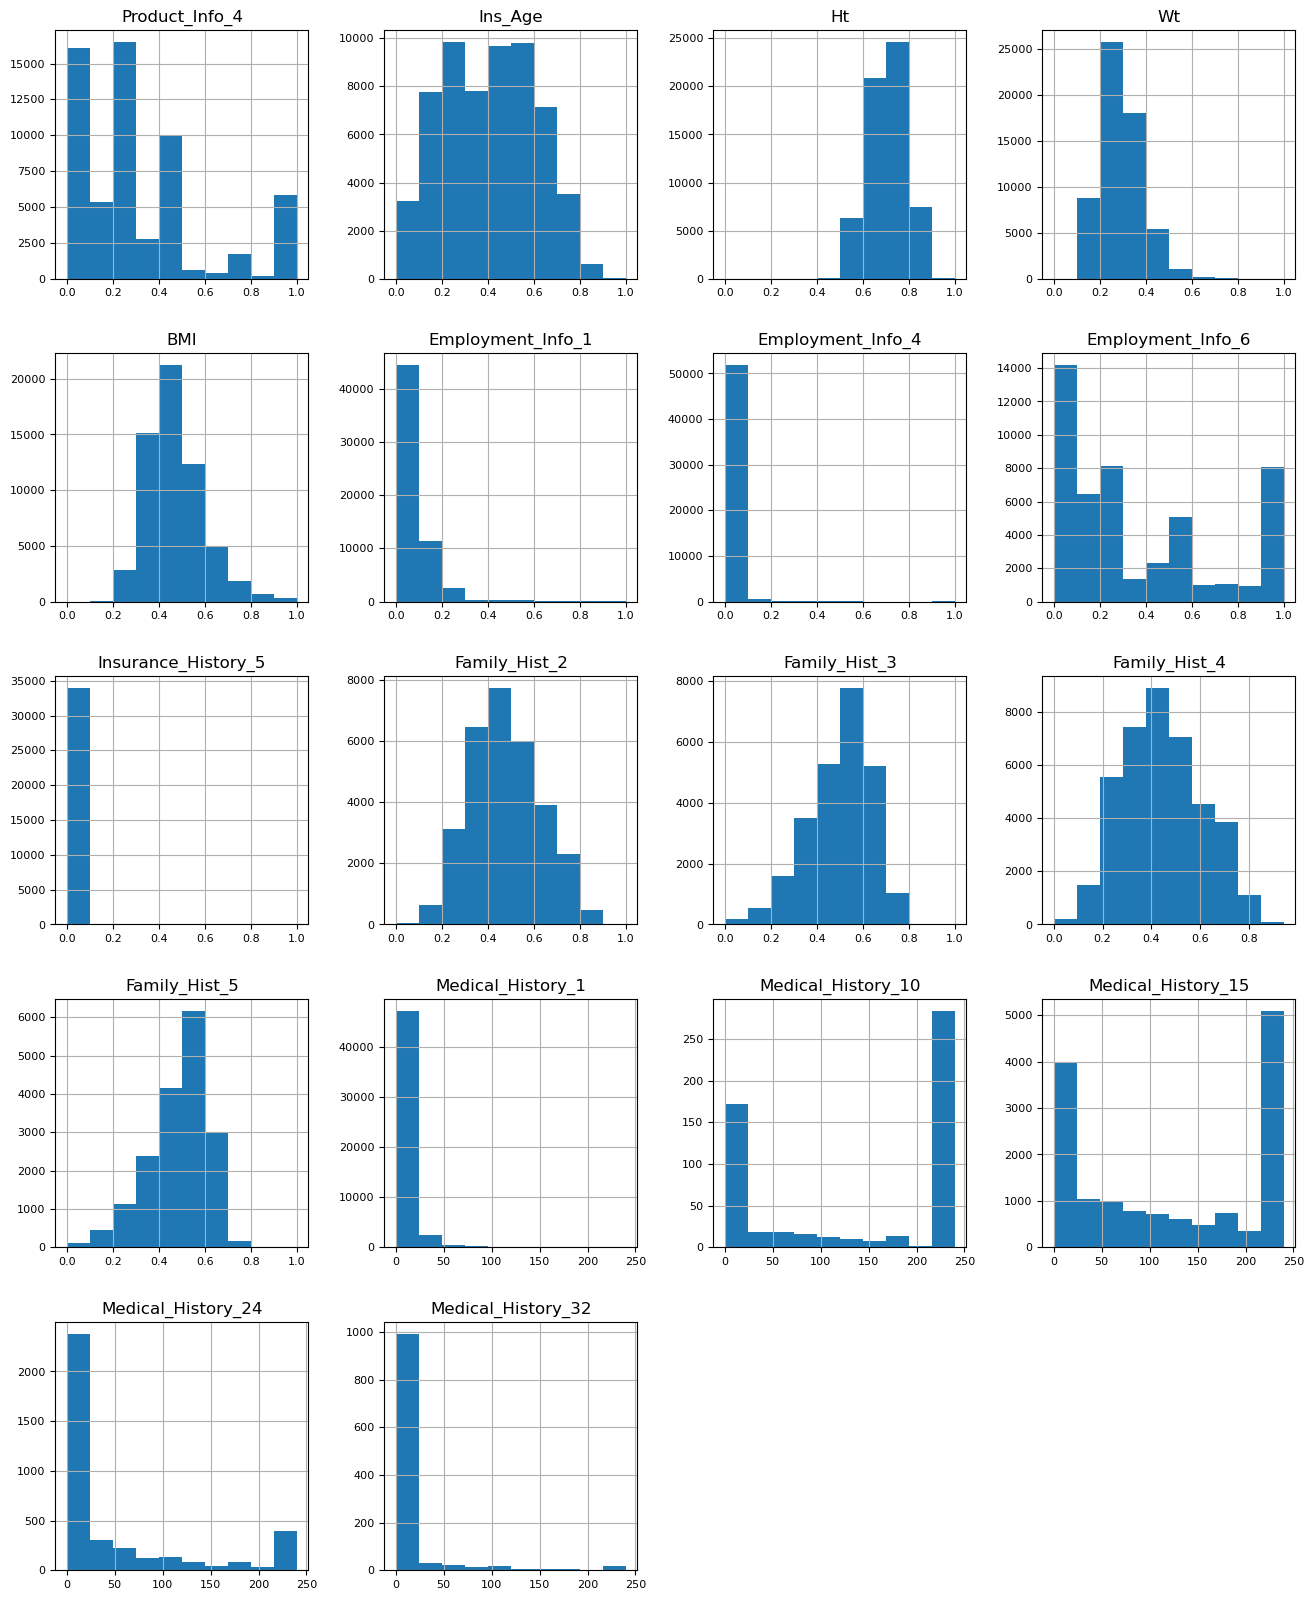

In [17]:
#Plot histograms of all numerical variables:
X_trainfull_num.hist(figsize=(16, 20),  xlabelsize=8, ylabelsize=8)  


##### From histgram plotting, we can clearly see Medical_History_24, Medical_History_32, Employment_Info_1, Medical_History_1, Employment_Info_4, Insurance_History_5 are highly skewed, while Medical_History_10 and Medical_History_15 are not perfectly symmetric even though they reported a good skewness value.

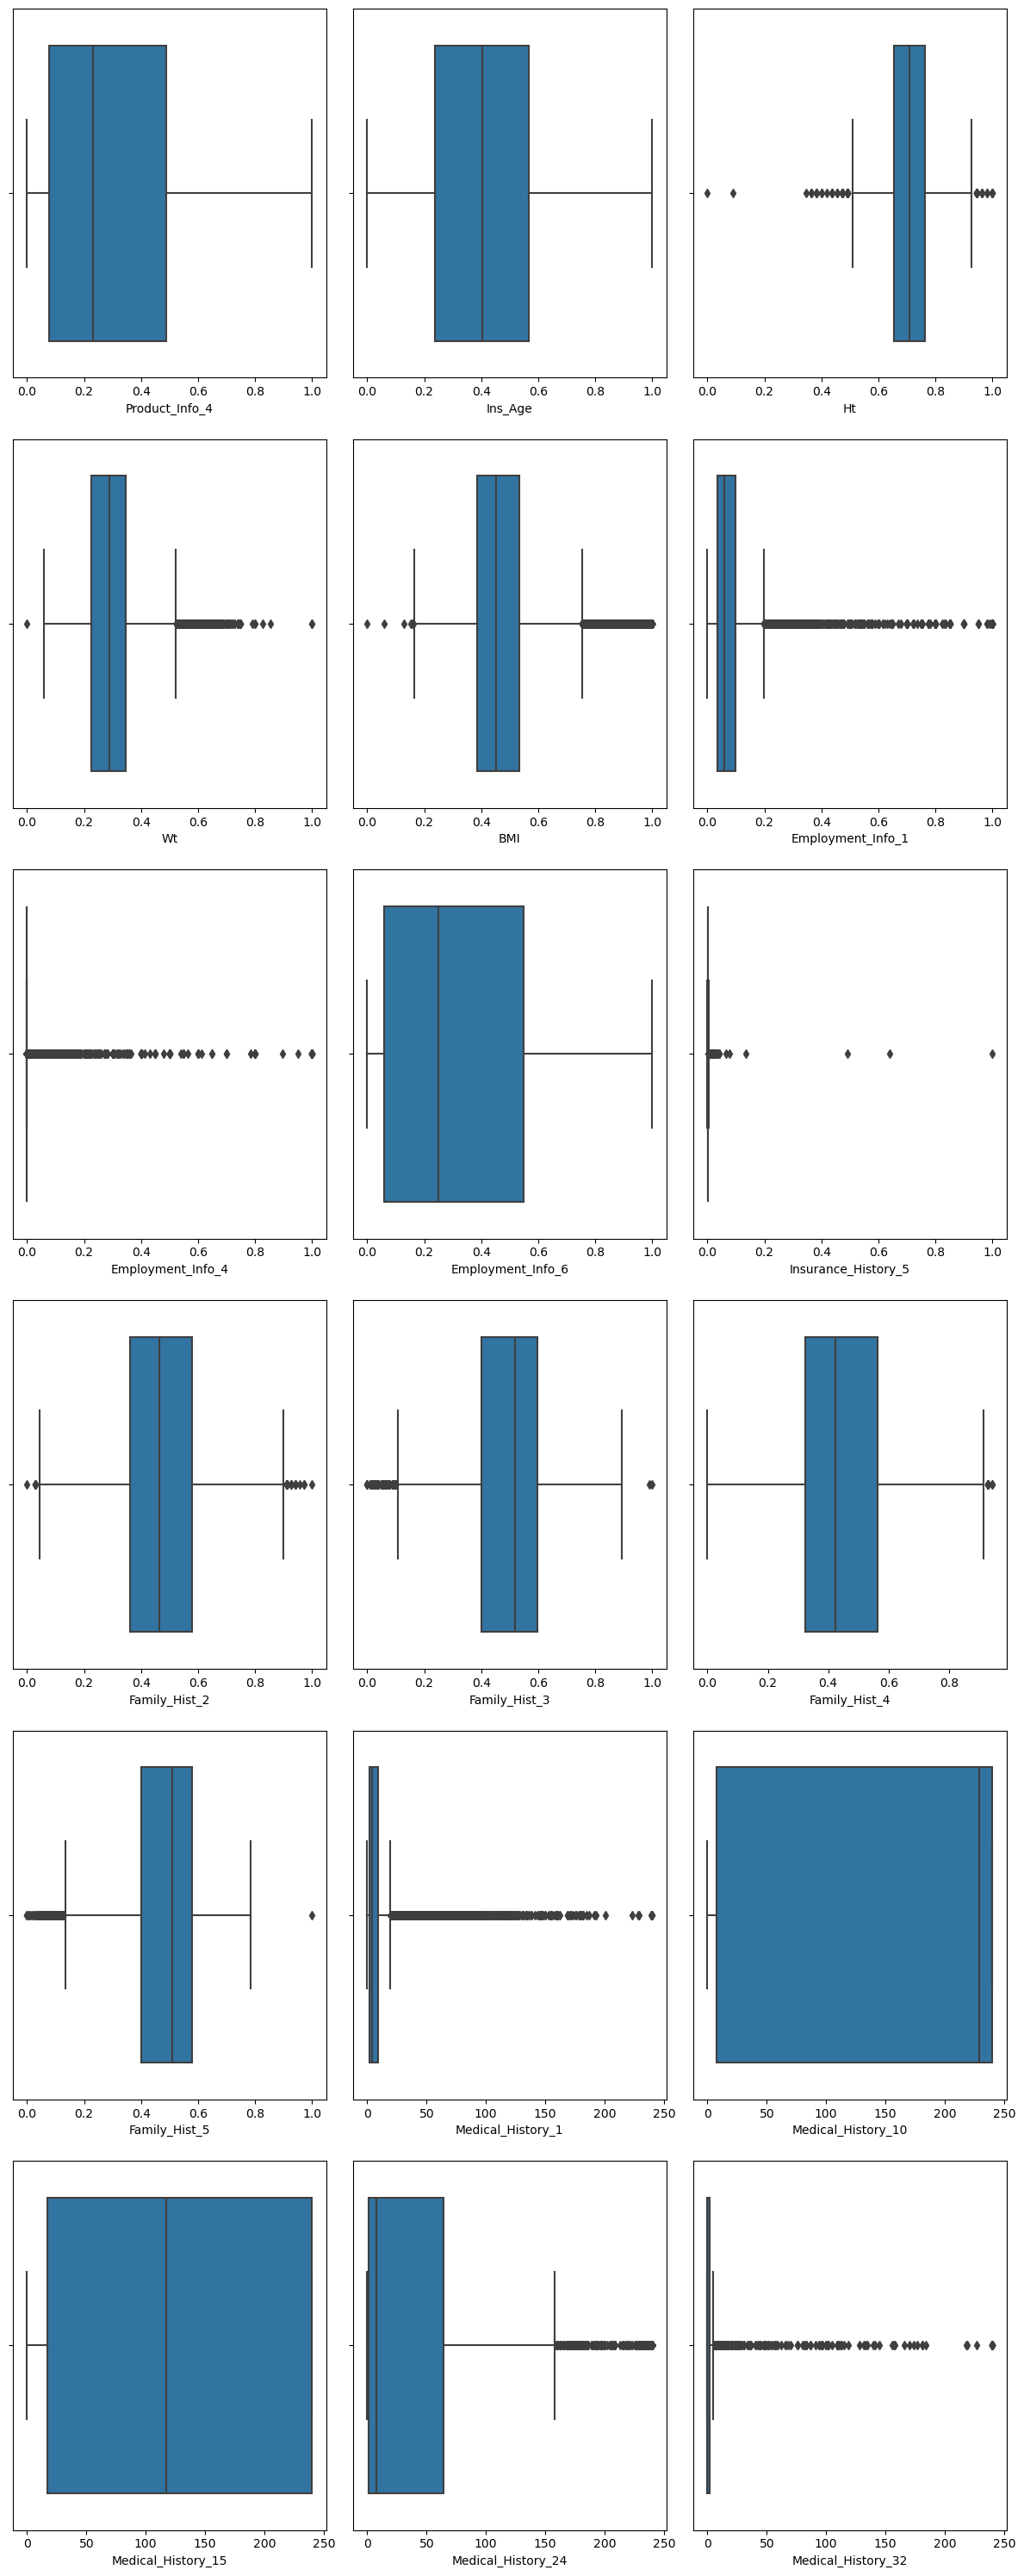

In [18]:
#Plot boxplots of all numerical variables:
fig, axes = plt.subplots(round(len(X_trainfull_num.columns) / 3), 3, figsize=(12, 30))
for i, ax in enumerate(fig.axes):
    if i < len(X_trainfull_num.columns): 
        sns.boxplot(x=X_trainfull_num.columns[i], data=X_trainfull_num, ax=ax)
plt.tight_layout(h_pad=2) 

##### From above boxplots, we can clearly see Medical_History_10 is skewed.

#### 2.4 Exploring Relationship between Variables

##### 2.4.1 Numerical to numerical relationships (the relationship between numerical features)

C:\Users\cclin\anaconda3\Lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


<Axes: >

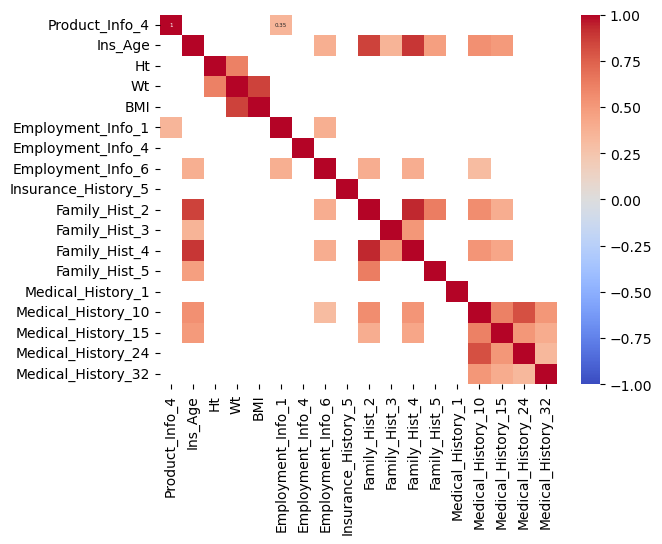

In [22]:
corr=X_trainfull_num.corr() #to get the correlations between every pair of numerical features
#to check how much correlation exists 
sns.heatmap(corr[corr.abs()>=0.3], vmin=-1, vmax=1, cmap='coolwarm', annot=True, annot_kws={'size':4})

##### From above filtered heatmap, there are in total 54 relationships  at least moderate correlated (>=0.3 or <=-0.3), which occupies 54/(17*18)=17.64%. This percentage is too low to apply PCA.

C:\Users\cclin\anaconda3\Lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


<Axes: >

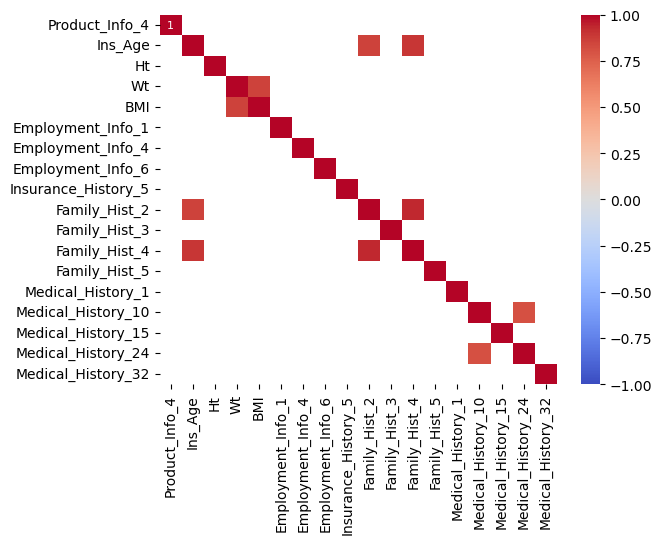

In [21]:
#to  display very high correlation coefficients
sns.heatmap(corr[(corr>=0.8) | (corr<= -0.8)], vmin=-1, vmax=1, cmap='coolwarm', annot=True, annot_kws={'size':8})

##### From above filtered heatmap, we can see:
- Ins_Age, Family_Hist_2 and Family_Hist_4 are highly correlated with each other
- Wt is highly correlated BMI
- Medical_History_10 is highly correlated Medical_History_24

These high correlations suggest redundancy, as one feature can be predicted with high accuracy from the other. In such cases, we might consider deleting one of the features to reduce multicollinearity and improve model performance.

C:\Users\cclin\anaconda3\Lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


<Axes: >

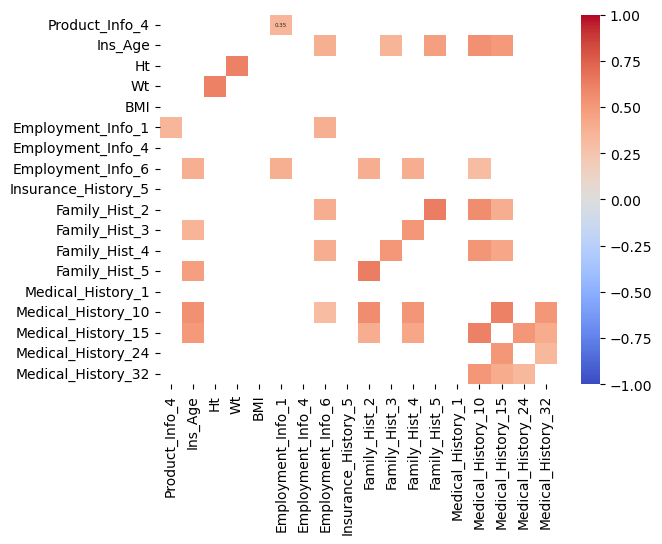

In [23]:
#to display moderate to high correlation coefficients
sns.heatmap(corr[(corr.abs()>=0.3) & (corr.abs()< 0.8)], vmin=-1, vmax=1, cmap='coolwarm', annot=True, annot_kws={'size':4})

##### From above filtered heatmap, we can see the moderate to high correlations (Between 0.3 and 0.8 or -0.3 and -0.8) include
- Product_Info_4 and Employment_Info_1
- Ins_Age and Employment_Info_6, or Family_Hist_3, or Family_Hist_5, or Medical_History_10, or Medical_History_15
- Ht and Wt
- Employment_Info_1 and Employment_Info_6
- Employment_Info_6 and Family_Hist_2, or Family_Hist_4, or Medical_History_10
- Family_Hist_2 and Family_Hist_5, or Medical_History_10, or Medical_History_15
- Family_Hist_3 and Family_Hist_4
- Family_Hist_4 and Medical_History_10, or Medical_History_15
- Medical_History_10 and Medical_History_15, or Medical_History_32
- Medical_History_15 and Medical_History_24, or Medical_History_32
- Medical_History_24 and Medical_History_32

we can consider creating interaction terms (like polynomial or sum or difference or ratio) between the features which are moderately to highly correlated. 

C:\Users\cclin\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\cclin\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\cclin\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\cclin\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

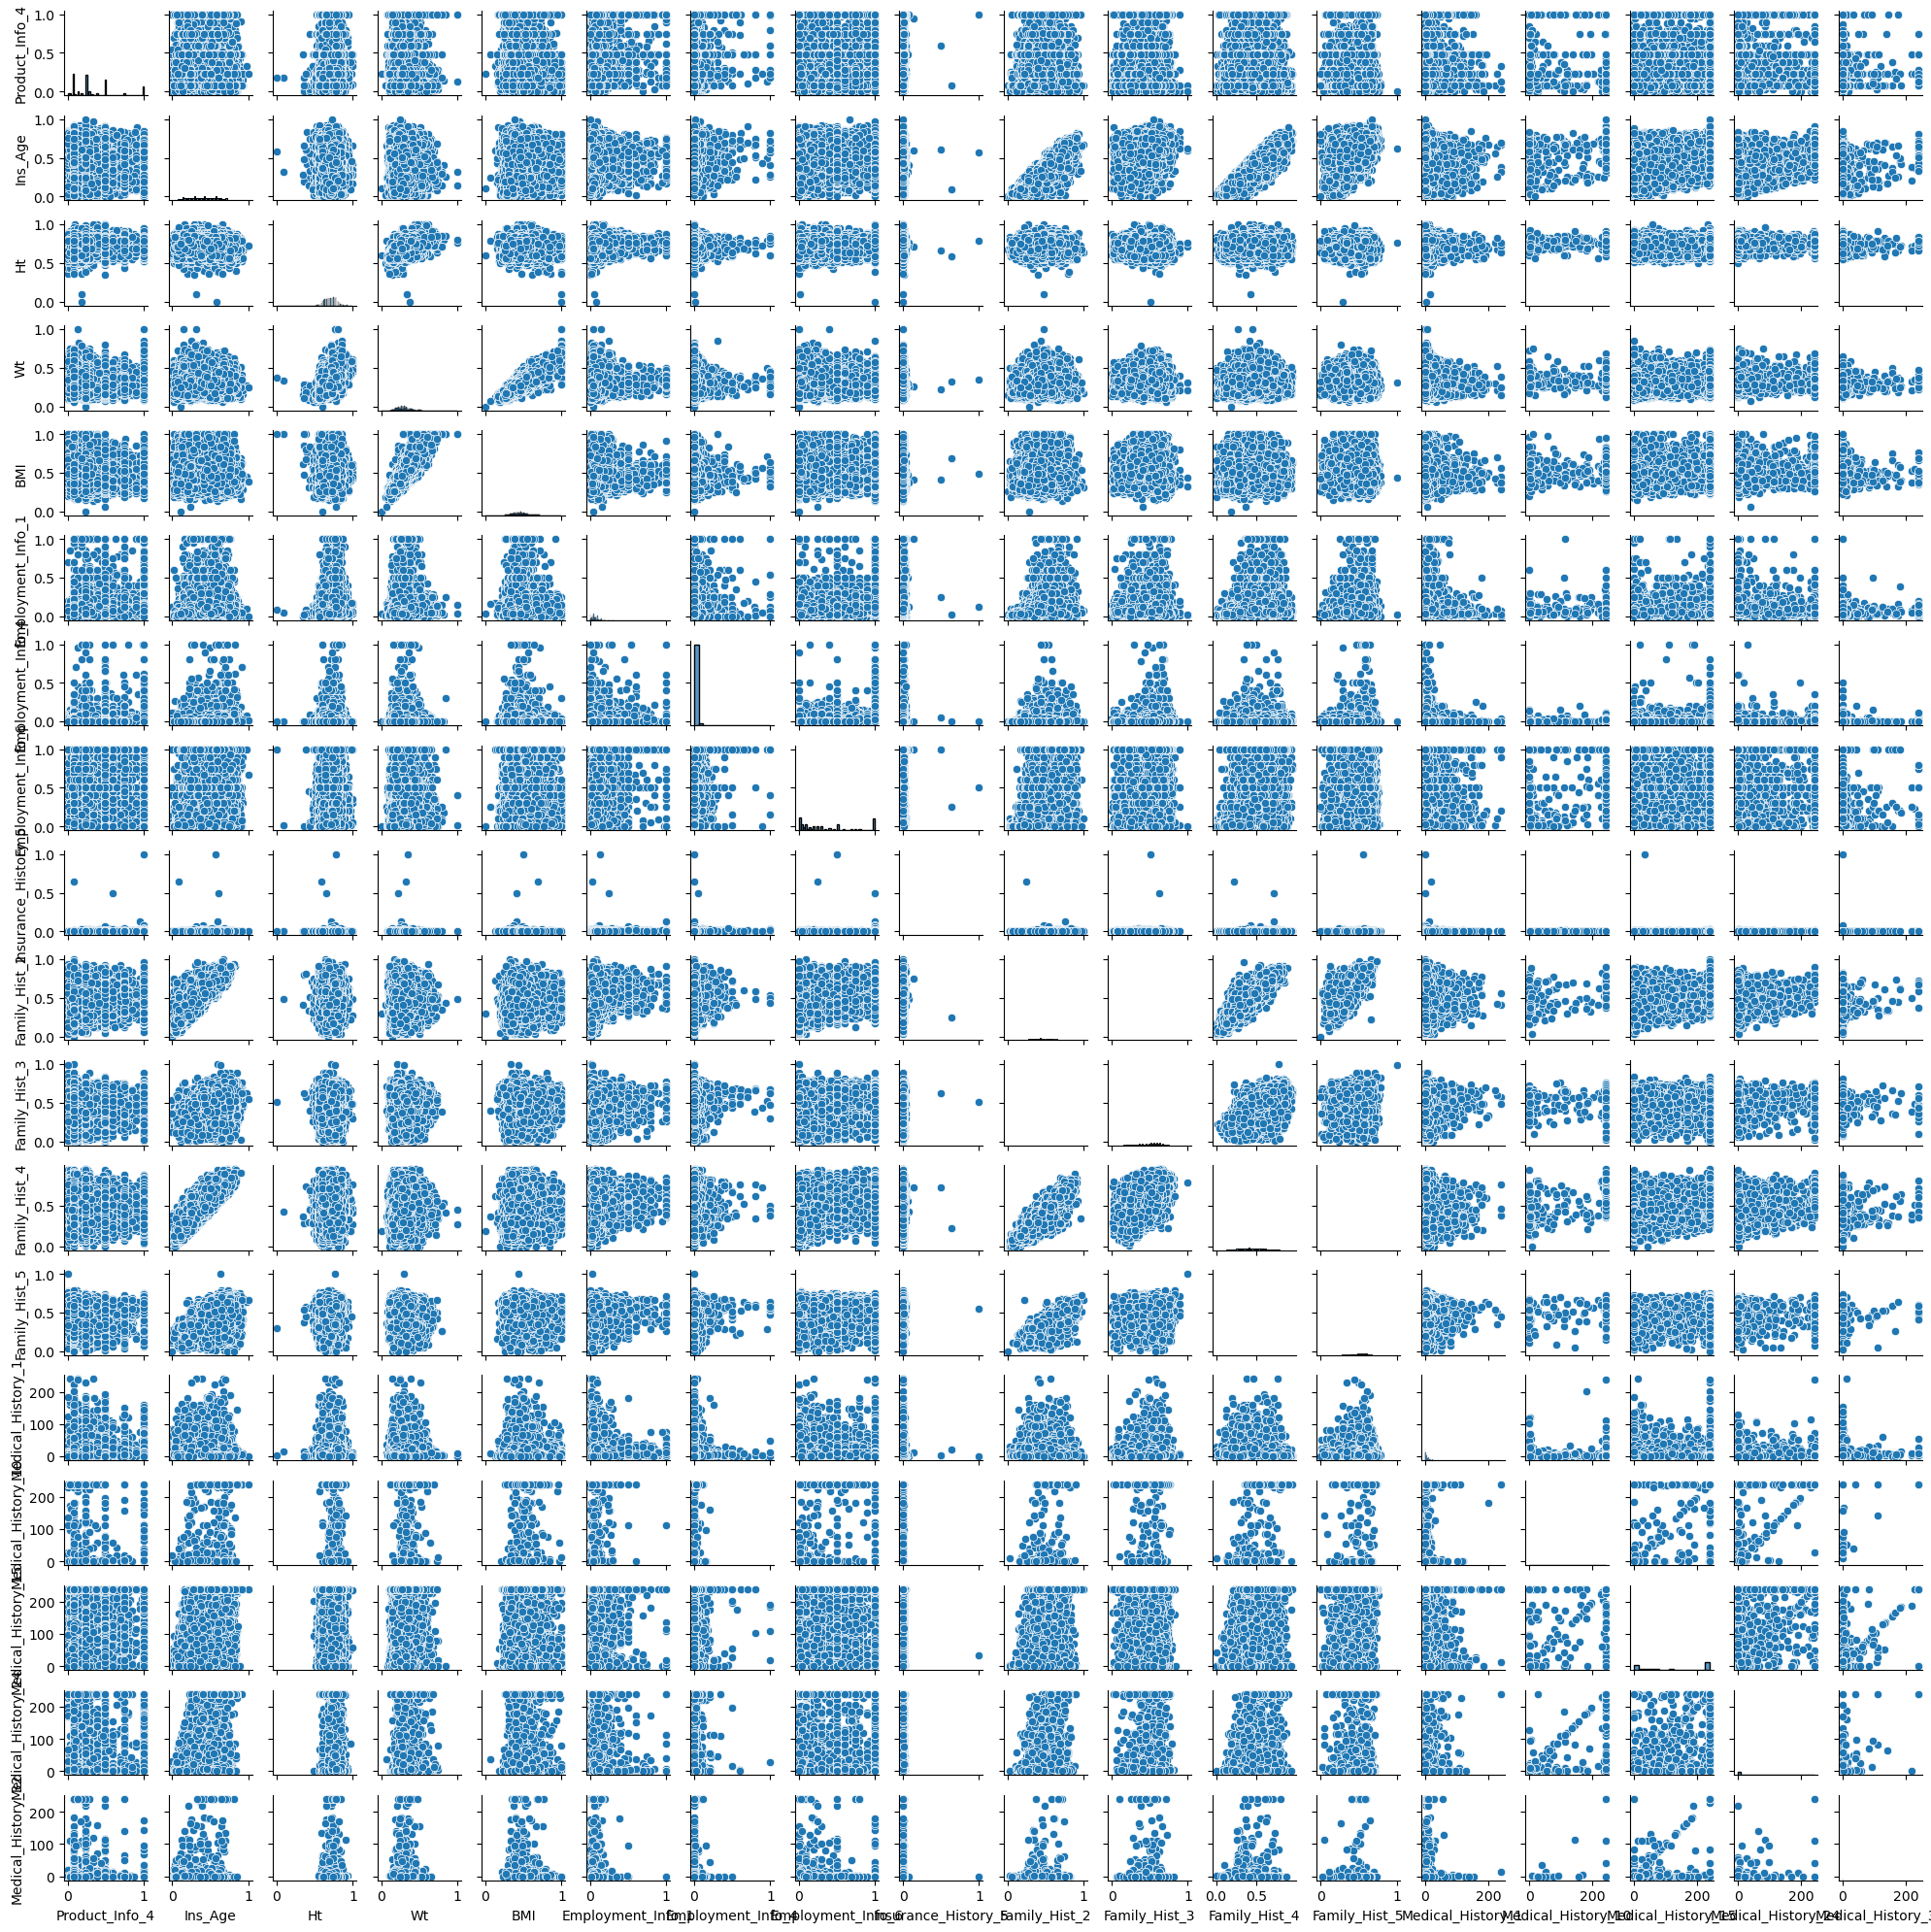

In [24]:
#to check scatter plots between different numerical features:
sns.pairplot(X_trainfull_num, height=5, aspect=1.5) #display the scatter plots for every pair of numerical features
plt.gcf().set_size_inches(20, 20)
plt.tight_layout()
plt.show()

##### From the above scatter plot, we can see the linear relationship exists between:
- Ins_Age and Family_Hist_2, Family_Hist_4
- Wt and BMI
- Family_Hist_2 and Family_Hist_4, Family_Hist_5
- Medical_Histroy_10 and Medical_History_15, Medical_History_24
- Medical_History_15 and Medical_History_32

which are all covered by the above two analysis. While this visual analyses provide insights, they lack the comprehensive detail offered by numerical analysis due to the limitations inherent in visual inspection.

##### 2.4.2 Categorical to numerical relationships (the relationship between categorical label and each of numerical features) 

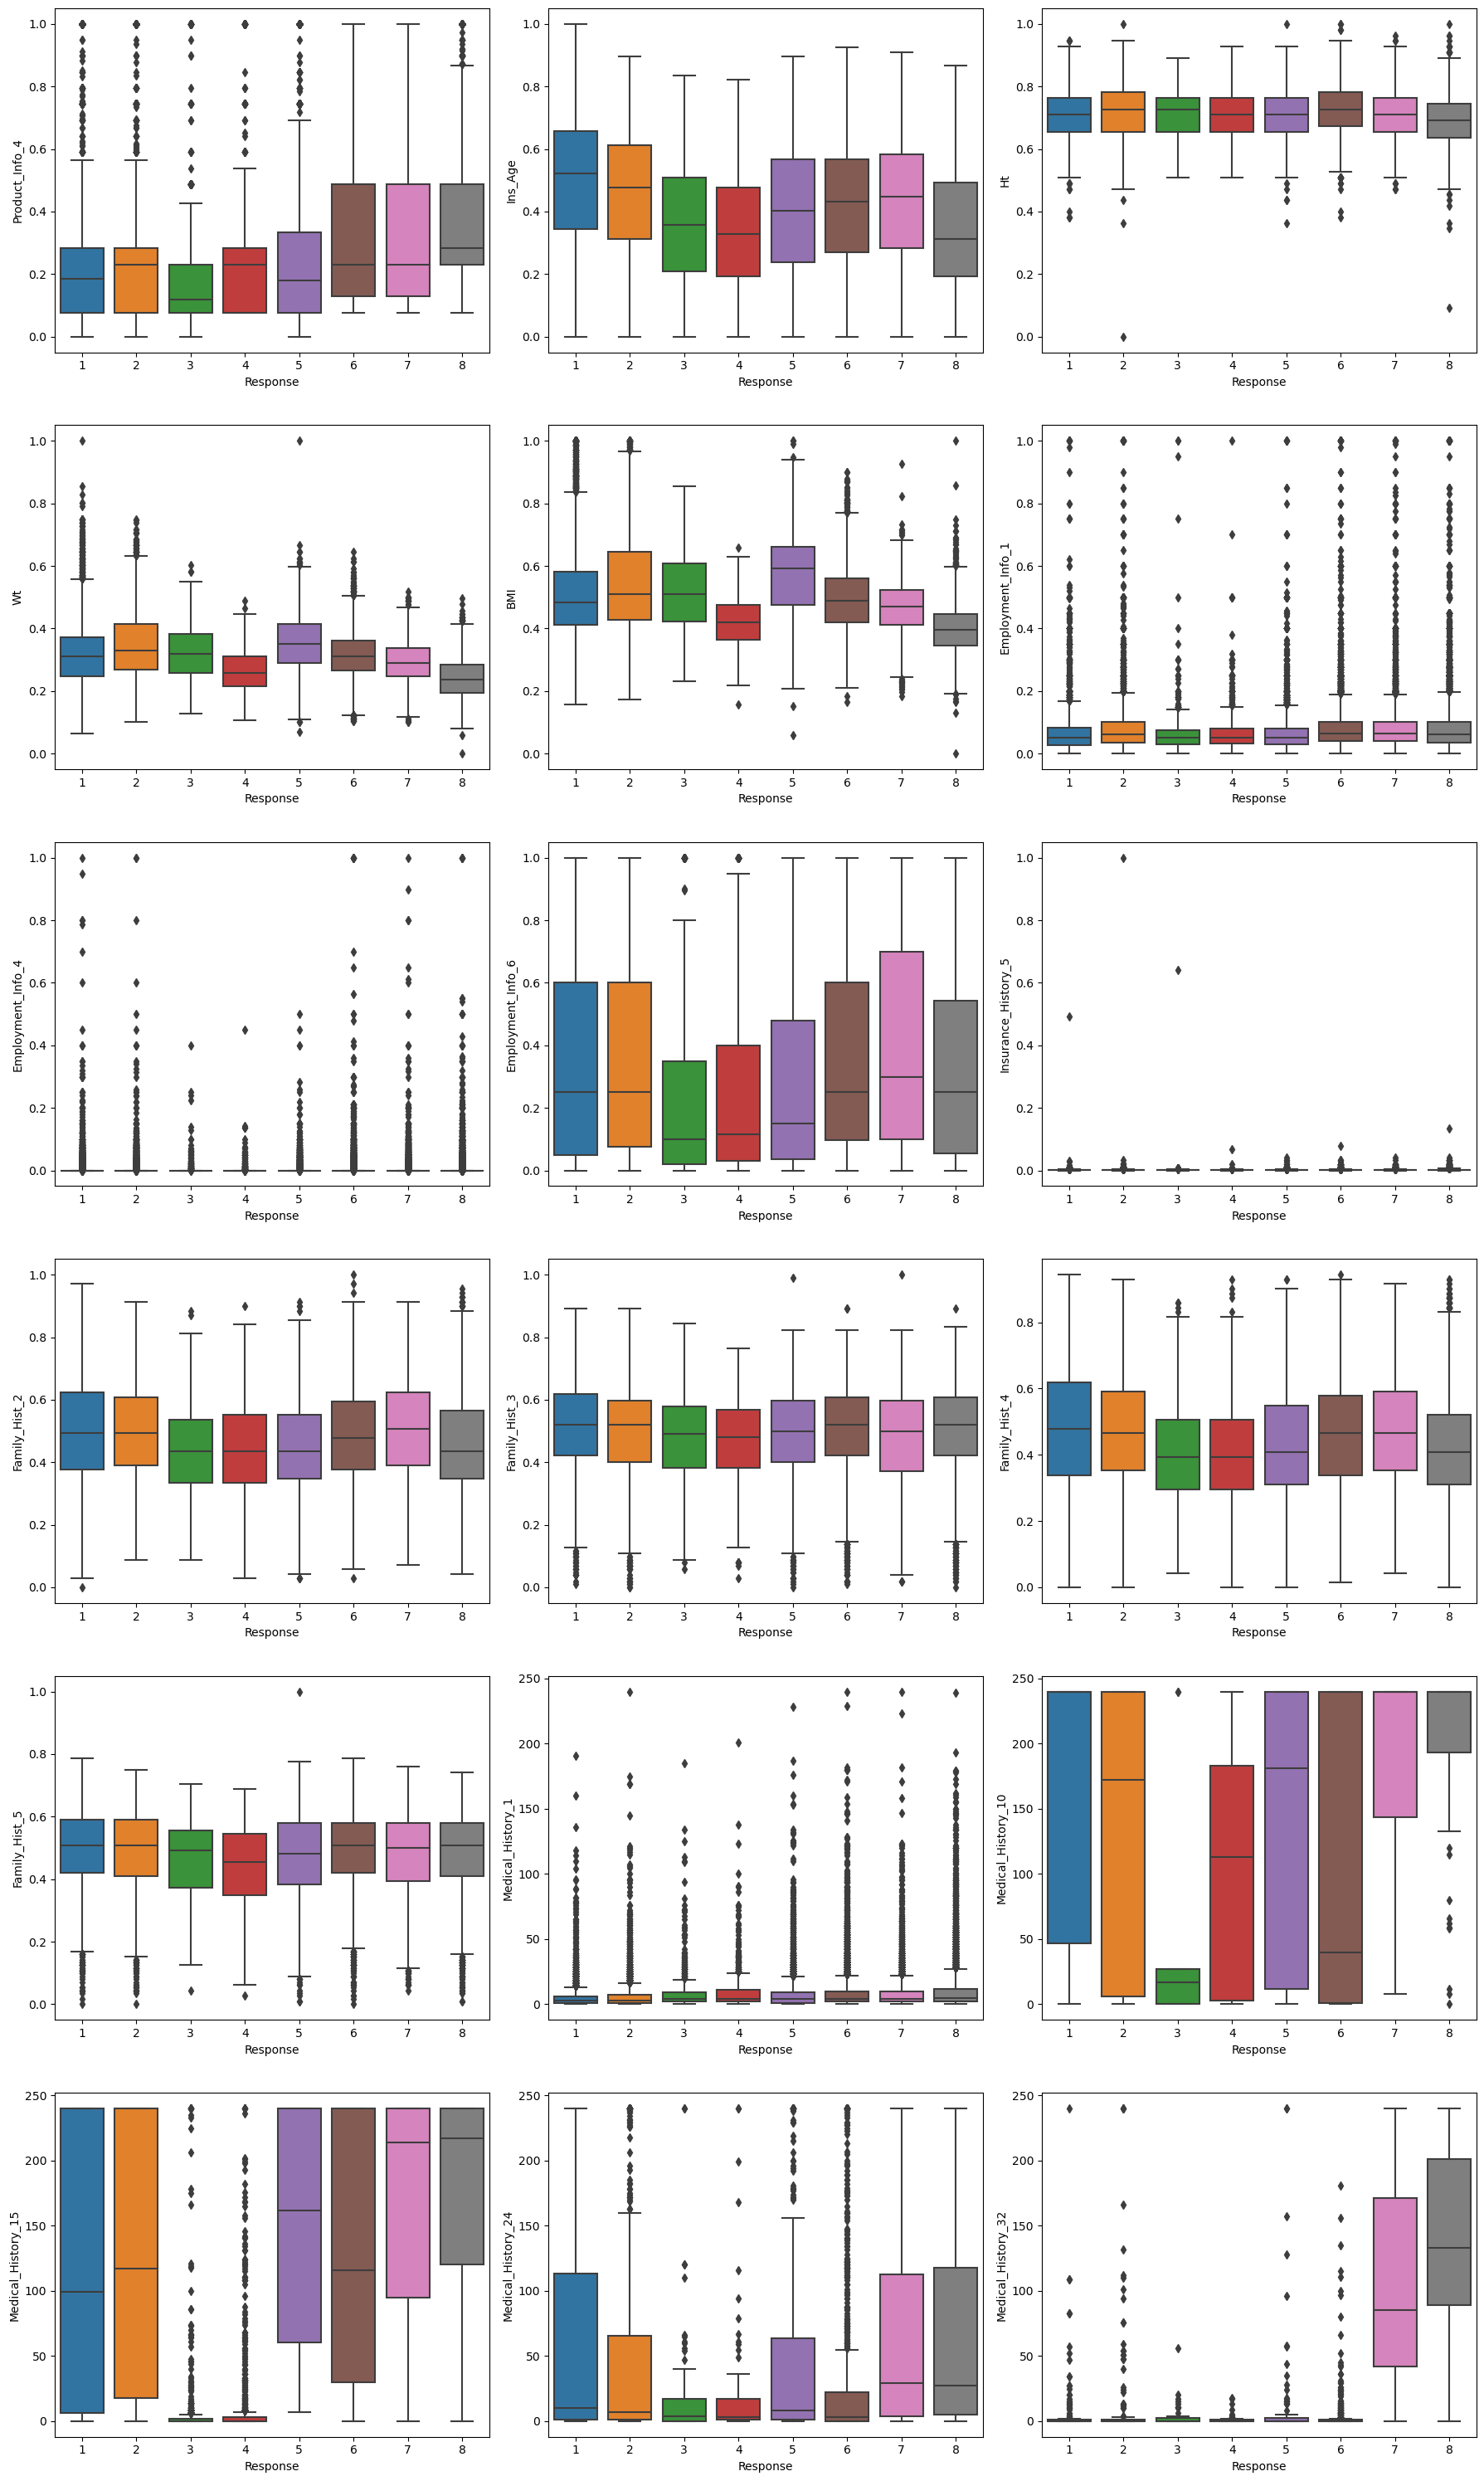

In [25]:
#combine all numerical features with the categorical label into a new dataframe
df_train_num_plus_label=pd.concat([X_trainfull_num, df_train_cat[['Response']]], axis=1)
num_numerical_features = df_train_num_plus_label.shape[1]-1 #the number of total numerical features
numcols = 3 # to display subplots by  3 columns
numrows = round(num_numerical_features / numcols) # get the total rows for the subplots display
fig_w = 18
fig, axes = plt.subplots(numrows, numcols, figsize = (18, 30))
for i, ax in enumerate(fig.axes): 
    if i < num_numerical_features: 
        #display the boxplot of each numerical feature under different categories of label
        sns.boxplot(x='Response', y=df_train_num_plus_label.columns[i], data=df_train_num_plus_label, ax=ax)
fig.tight_layout(h_pad=3)


##### From above boxplots, we can see:
- Ht,  Family_Hist_2, Family_Hist_3, Family_Hist_4, Family_Hist_5 appear to be less useful as features.;
- Medical_History_10, Medical_History_15, Medical_History_24, and Medical_History_32 seem to be important features;
- Employment_Info_1, Medical_History_1, Insurance_History_5 and Employment_Info_4 are challenging to assess due to their high skewness.;
- The remaining features likely hold moderate to high importance.

##### 2.4.3 Categorical to categorical relationships (the relationship between categorical label and each of categorical features) 

<Figure size 640x480 with 0 Axes>

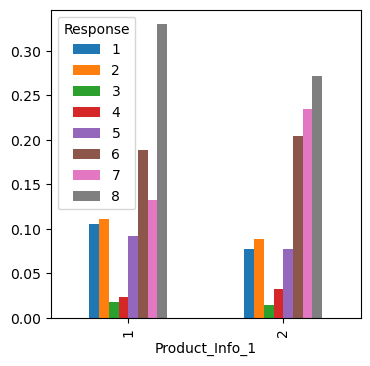

<Figure size 640x480 with 0 Axes>

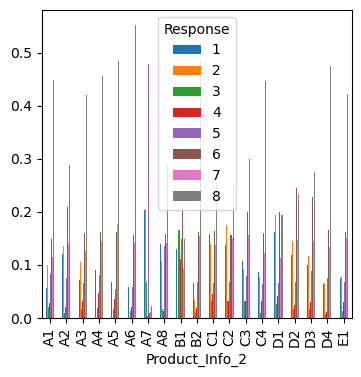

<Figure size 640x480 with 0 Axes>

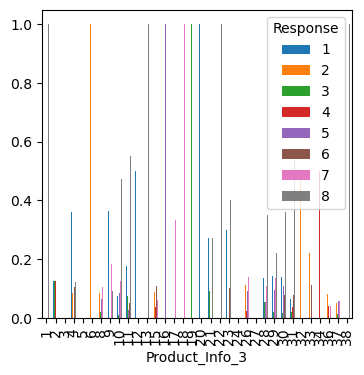

<Figure size 640x480 with 0 Axes>

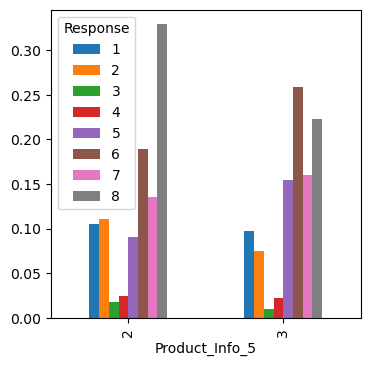

<Figure size 640x480 with 0 Axes>

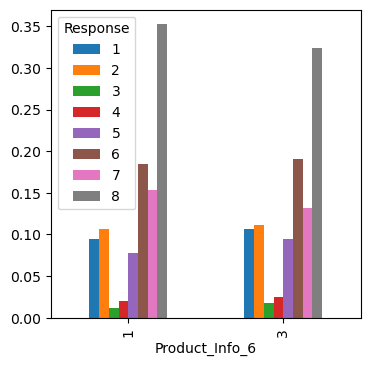

<Figure size 640x480 with 0 Axes>

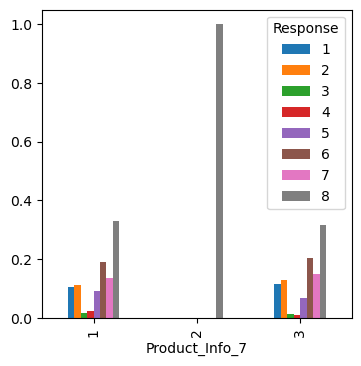

<Figure size 640x480 with 0 Axes>

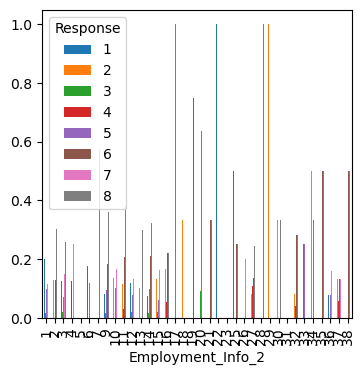

<Figure size 640x480 with 0 Axes>

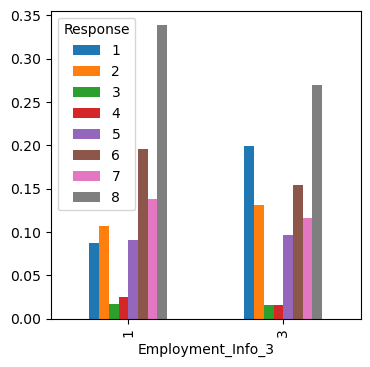

<Figure size 640x480 with 0 Axes>

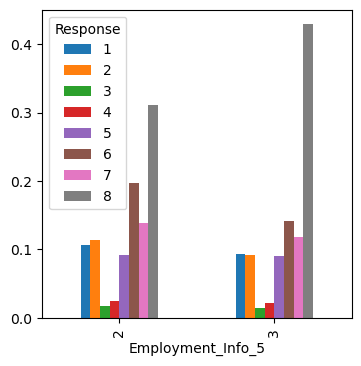

<Figure size 640x480 with 0 Axes>

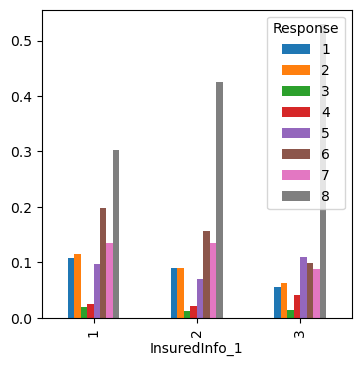

<Figure size 640x480 with 0 Axes>

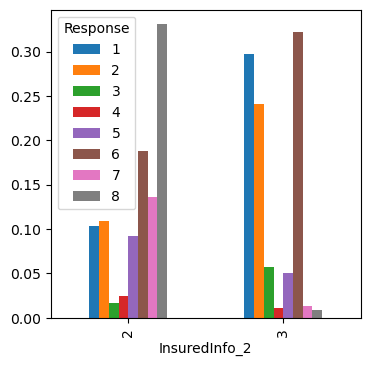

<Figure size 640x480 with 0 Axes>

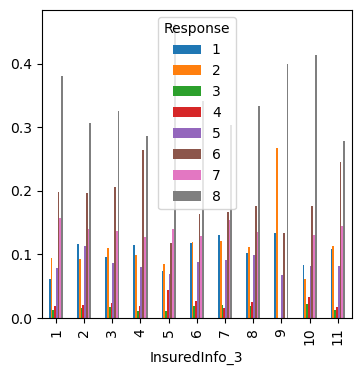

<Figure size 640x480 with 0 Axes>

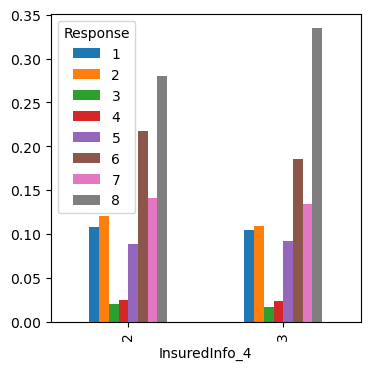

<Figure size 640x480 with 0 Axes>

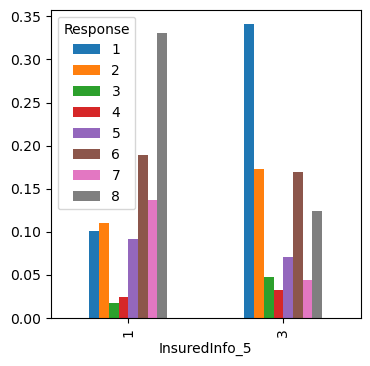

<Figure size 640x480 with 0 Axes>

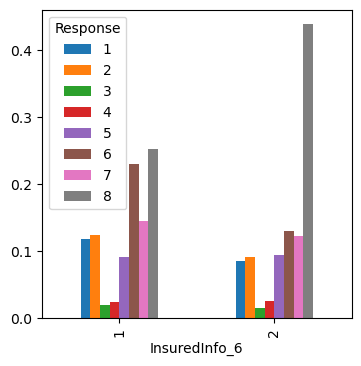

<Figure size 640x480 with 0 Axes>

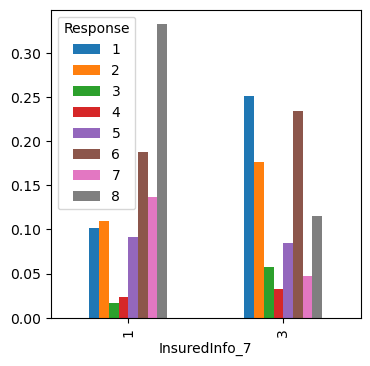

<Figure size 640x480 with 0 Axes>

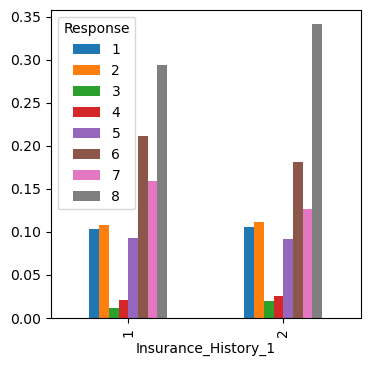

<Figure size 640x480 with 0 Axes>

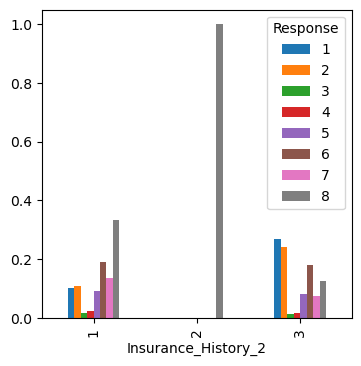

<Figure size 640x480 with 0 Axes>

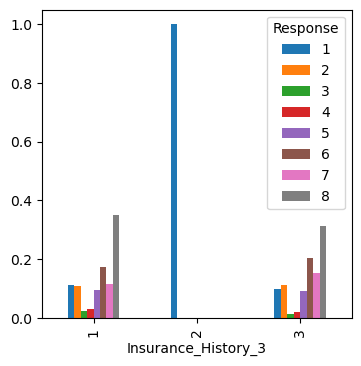

<Figure size 640x480 with 0 Axes>

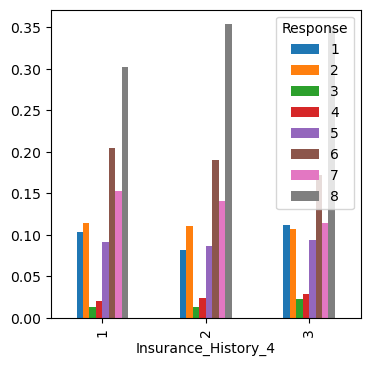

<Figure size 640x480 with 0 Axes>

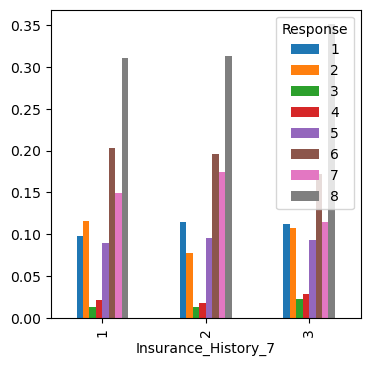

<Figure size 640x480 with 0 Axes>

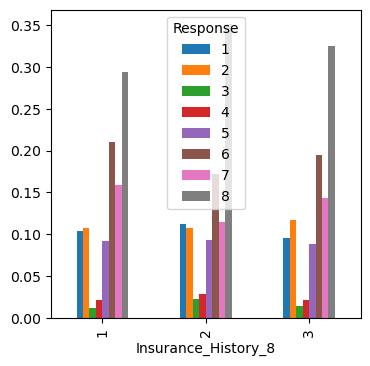

<Figure size 640x480 with 0 Axes>

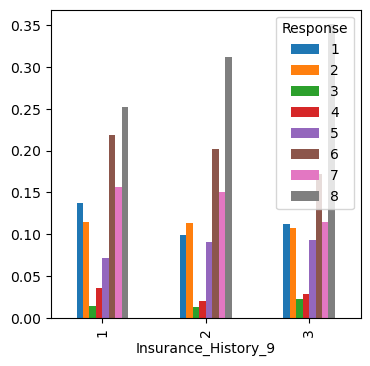

<Figure size 640x480 with 0 Axes>

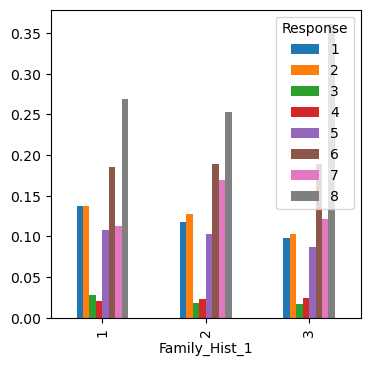

<Figure size 640x480 with 0 Axes>

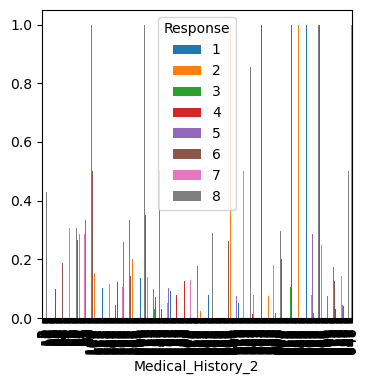

<Figure size 640x480 with 0 Axes>

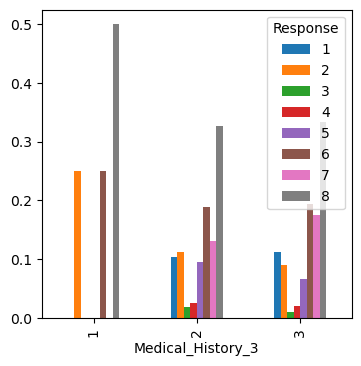

<Figure size 640x480 with 0 Axes>

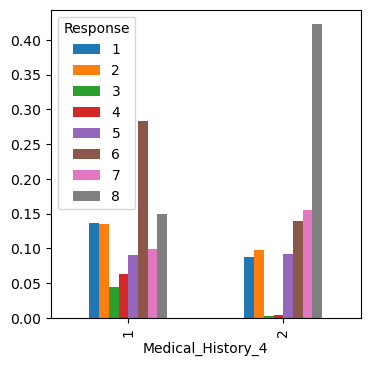

<Figure size 640x480 with 0 Axes>

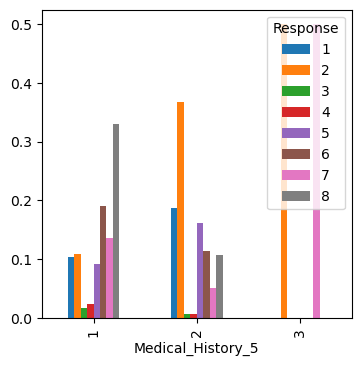

<Figure size 640x480 with 0 Axes>

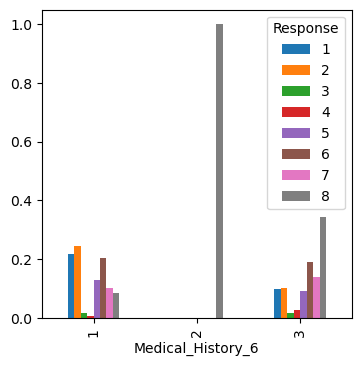

<Figure size 640x480 with 0 Axes>

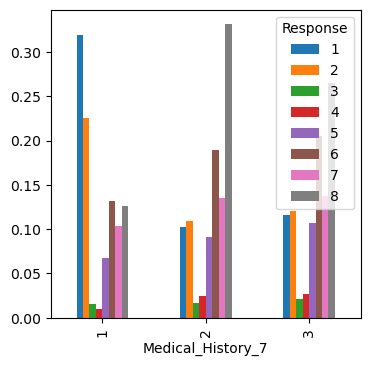

<Figure size 640x480 with 0 Axes>

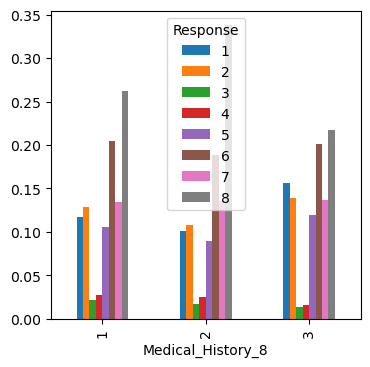

<Figure size 640x480 with 0 Axes>

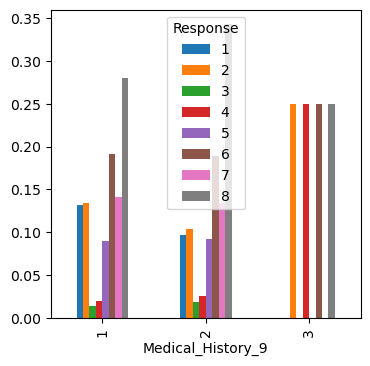

<Figure size 640x480 with 0 Axes>

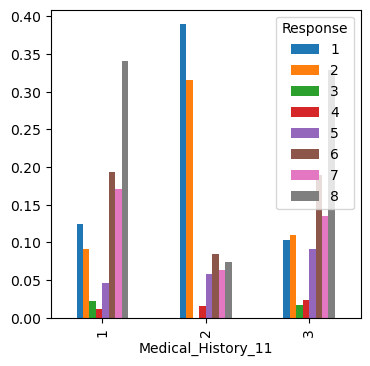

<Figure size 640x480 with 0 Axes>

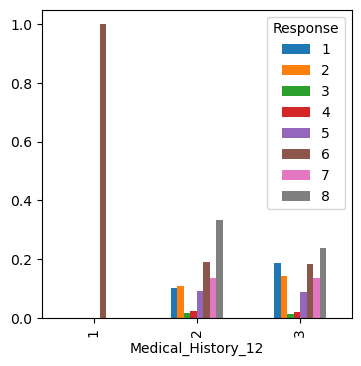

<Figure size 640x480 with 0 Axes>

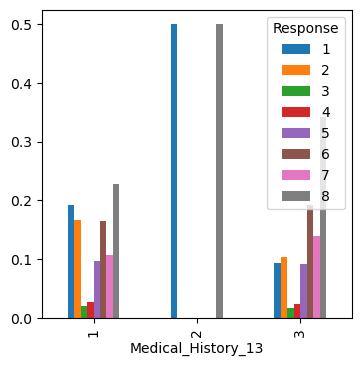

<Figure size 640x480 with 0 Axes>

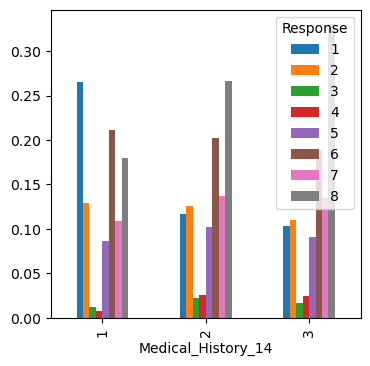

<Figure size 640x480 with 0 Axes>

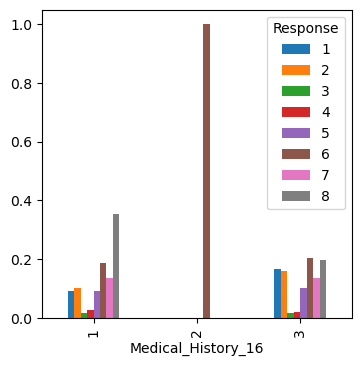

<Figure size 640x480 with 0 Axes>

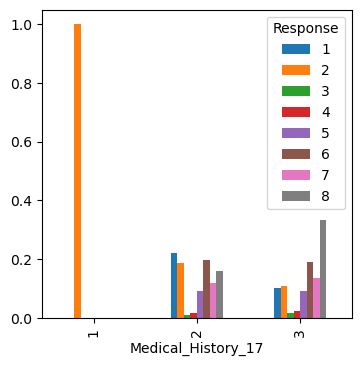

<Figure size 640x480 with 0 Axes>

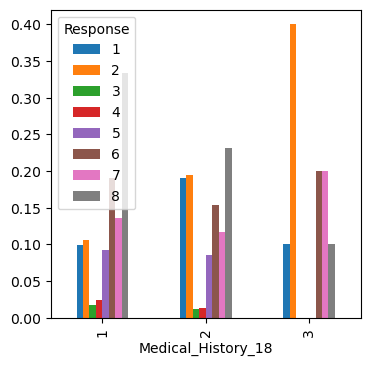

<Figure size 640x480 with 0 Axes>

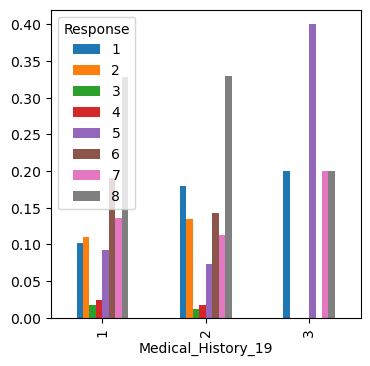

<Figure size 640x480 with 0 Axes>

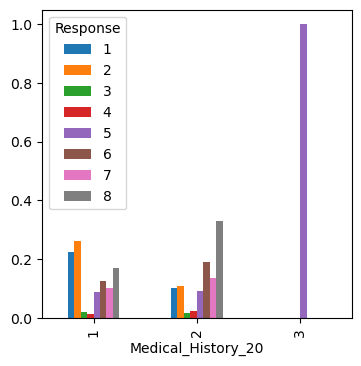

<Figure size 640x480 with 0 Axes>

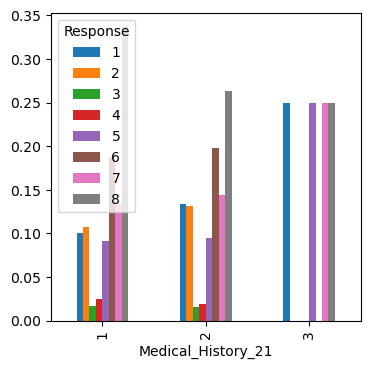

<Figure size 640x480 with 0 Axes>

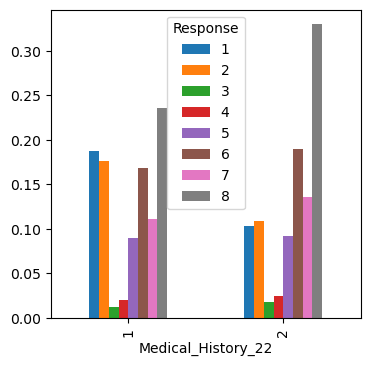

<Figure size 640x480 with 0 Axes>

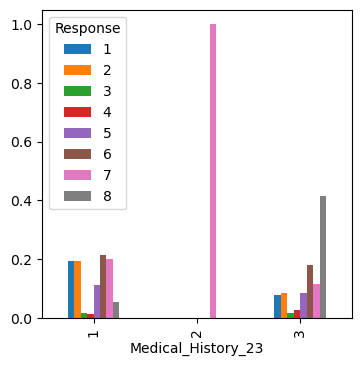

<Figure size 640x480 with 0 Axes>

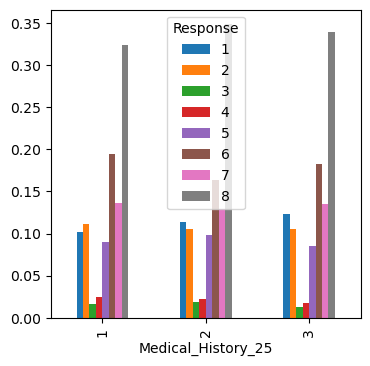

<Figure size 640x480 with 0 Axes>

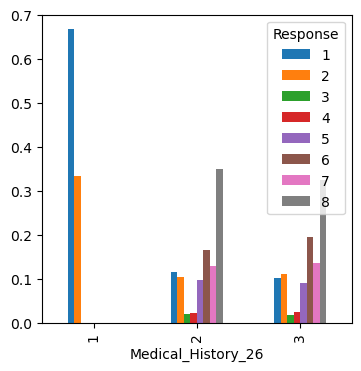

<Figure size 640x480 with 0 Axes>

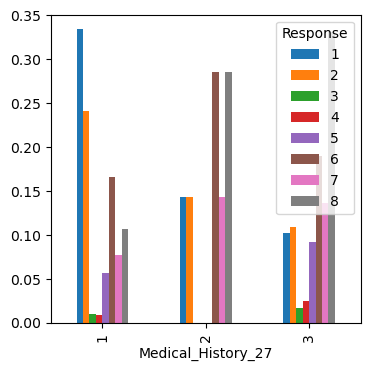

<Figure size 640x480 with 0 Axes>

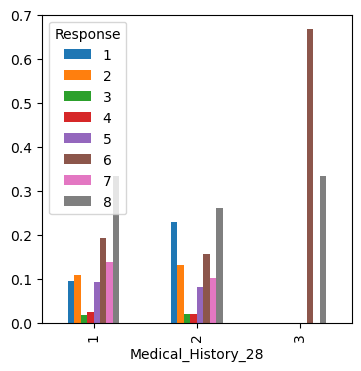

<Figure size 640x480 with 0 Axes>

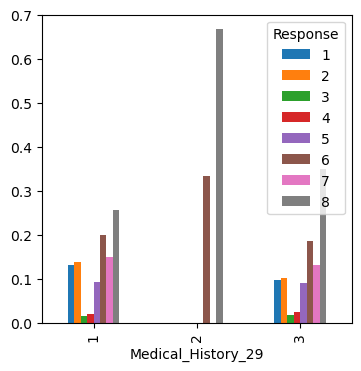

<Figure size 640x480 with 0 Axes>

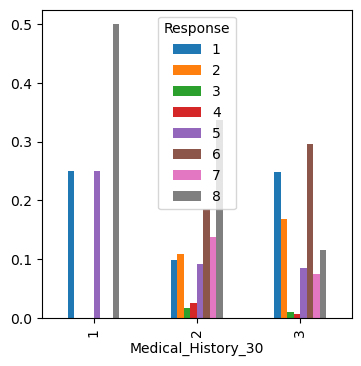

<Figure size 640x480 with 0 Axes>

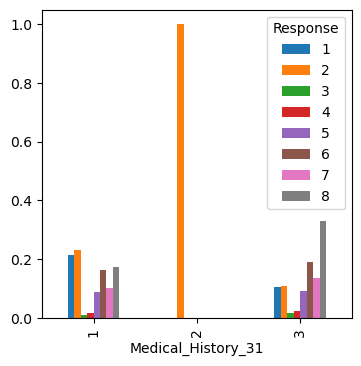

<Figure size 640x480 with 0 Axes>

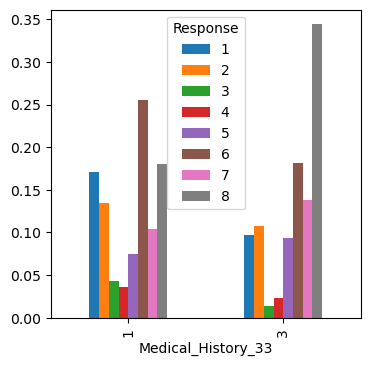

<Figure size 640x480 with 0 Axes>

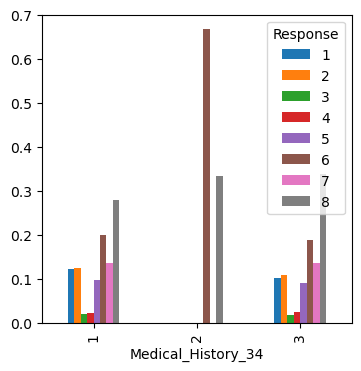

<Figure size 640x480 with 0 Axes>

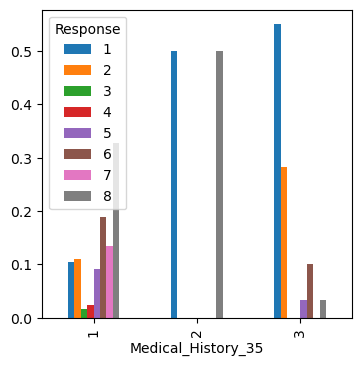

<Figure size 640x480 with 0 Axes>

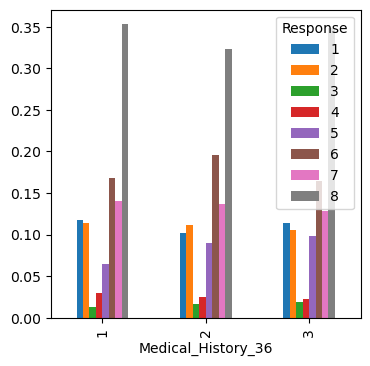

<Figure size 640x480 with 0 Axes>

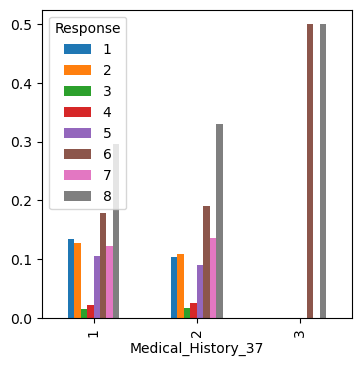

<Figure size 640x480 with 0 Axes>

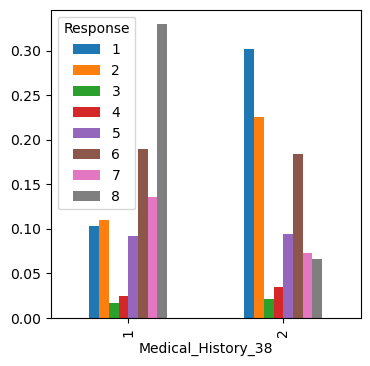

<Figure size 640x480 with 0 Axes>

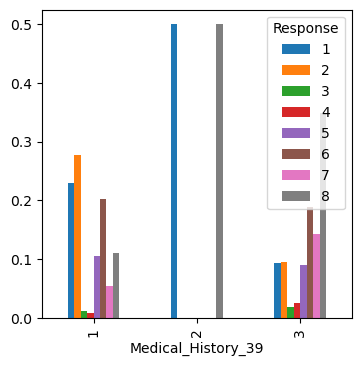

<Figure size 640x480 with 0 Axes>

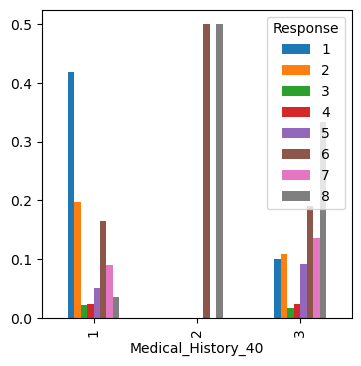

<Figure size 640x480 with 0 Axes>

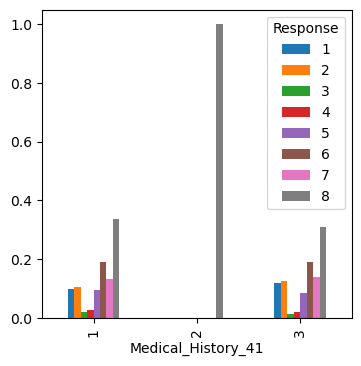

In [26]:
#define a custom function to return the proportion distribution of the categorical label under each category of a given
# categorical feature
def catLabel_proportiondist_vs_catFeature(catFeature):
    catLprop_catF = df_train_cat.groupby([catFeature])['Response'].value_counts(normalize=True).unstack()
    ax = catLprop_catF.plot(kind='bar', figsize=(4, 4))
    return ax
# Loop through all categorical features and display plots
for i in range(len(df_train_cat.columns)-1):
    plt.figure()  # Create a new figure for each plot
    catFeature = df_train_cat.columns[i]
    catLabel_proportiondist_vs_catFeature(catFeature)
    plt.show()  # Display the plot

##### From above plots, we can see the following categorical features do not appear to significantly influence the label class proportion distribution:
- Product_Info_6
- InsuredInfo_4
- Insurance_History_1
- Insurance_History_4
- Insurance_History_8
- Medical_History_25
- Medical_History_36

These features can be considered to drop. If they are to be retained, one-hot encoding may be appropriate. The remaining features should be considered for target encoding.

##### In Summary, Based on the Whole EDA, We Can Conclude:

- **Missing Data Handling**:
  - **To Drop**:
    - `Family_Hist_5 (70%missing)` 
    - `Family_Hist_3 (58%missing)` 
    - `Family_Hist_2 (48%missing)` 
    - `Family_Hist_4 (32%missing)` 
  - **To Be Determined (TBD)**:
    - `Medical_History_10` (99%missing), `Medical_History_15` (75%missing), `Medical_History_24` (94%missing), and `Medical_History_32` (98%missing) have significant missing values but show strong importance to the label. However, this might be suspicious since the large boxplot variation across different label categories could be due to insufficient data. XGBoost should be used to double-check their importance.
    - `Insurance_History_5` (continuous, 43%missing) is highly skewed (skewness over 100). Its importance is difficult to assess due to this high skewness. XGBoost can be used to verify its importance.
  - **To Fill**:
    - `Employment_Info_6` (continuous, filled by median)
    - `Medical_History_1` (discrete, filled by mode)
    - `Employment_Info_4` (continuous, filled by median)
    - `Employment_Info_1` (continuous, filled by median)
    
    *Median imputation is chosen because these features are skewed.*

- **Categorical Feature Handling**:
  - **To Drop**:
    - `Product_Info_6`
    - `InsuredInfo_4`
    - `Insurance_History_1`
    - `Insurance_History_4`
    - `Insurance_History_8`
    - `Medical_History_25`
    - `Medical_History_36`  
  - The remaining categorical features should be considered for target encoding.

- **Numerical Features Handling**:
  - **To Drop**:
    - `Wt` (redundancy)
    - 'Ht' (less importance)

  - **To Create**:
    - Interaction terms: 
      - `Product_Info_4 and Employment_Info_1`
      - `Ins_Age  and Employment_Info_6`
      - `Employment_Info_1  and Employment_Info_6`
  - **To Apply**:
    - Box-Cox transformation to all numerical features except `Ins_Age`. Features like `Product_Info_4`, `Employment_Info_1`, `Medical_History_1`, `Employment_Info_4`, and `Insurance_History_5` are highly right-skewed (may also include some new interaction terms), with `Insurance_History_5` being particularly extreme. Check these highly skewed features after transformation to see if they remain skewed. If so, they may need further handling, such as outlier management or feature engineering (binning). After addressing skewness, apply data scaling to all numerical features.


### Chapter 3: Feature Engineering

In [27]:
# change all the categorical features into the type of 'category'
X_trainfull_cat=df_train_cat.iloc[:,:-1]
X_trainfull_cat=X_trainfull_cat.apply(lambda x: x.astype('category'))


In [28]:
#extract the dummy features
dummy_features=df_train.loc[:, 'Medical_Keyword_1':'Medical_Keyword_48']

In [29]:
# create X_train_full by including all features 
X_train_full=pd.concat([X_trainfull_num, X_trainfull_cat, dummy_features],axis=1)
X_train_full.shape

(59381, 126)

In [30]:
X_train_full.info()

<class 'pandas.core.frame.DataFrame'>
Index: 59381 entries, 2 to 79146
Columns: 126 entries, Product_Info_4 to Medical_Keyword_48
dtypes: category(60), float64(18), int64(48)
memory usage: 33.8 MB


In [31]:
# create y_train_full
y_train_full=df_train.iloc[:,-1]
y_train_full.shape

(59381,)

In [32]:
# convert the label classes from 1-8 to 0-7 for standard convention
y_train_full=y_train_full.map(lambda x: x-1)

In [33]:
y_train_full.value_counts()

Response
7    19489
5    11233
6     8027
1     6552
0     6207
4     5432
3     1428
2     1013
Name: count, dtype: int64

In [34]:
X_train_full.shape

(59381, 126)

In [14]:
!pip install xgboost

In [255]:
#  Regard Xgboost as the base model, check the base performance 
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, make_scorer
# Split the data into training and validation sets with stratified sampling
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, 
    test_size=0.3,  # Adjust the proportion as needed
    stratify=y_train_full,  # Ensure class distribution is preserved
    random_state=123
)

# Initialize XGBClassifier with parameters


xgb_cl = xgb.XGBClassifier(
    objective="multi:softmax",
    num_class=8,
    enable_categorical=True,
    random_state=123
)



# Train the model
xgb_cl.fit(X_train, y_train)



# Predict and evaluate the model
val_preds = xgb_cl.predict(X_val)
accuracy = accuracy_score(y_val, val_preds)
f1 = f1_score(y_val, val_preds, average='macro') # for imbalanced labels, 'macro' is more appropriate.
performance_result=pd.Series({'accuracy': accuracy, 'f1': f1})
print(performance_result)


accuracy    0.580634
f1          0.507875
dtype: float64


C:\Users\cclin\AppData\Local\Temp\ipykernel_25996\3854470460.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(),  fontsize=30, fontweight='bold')


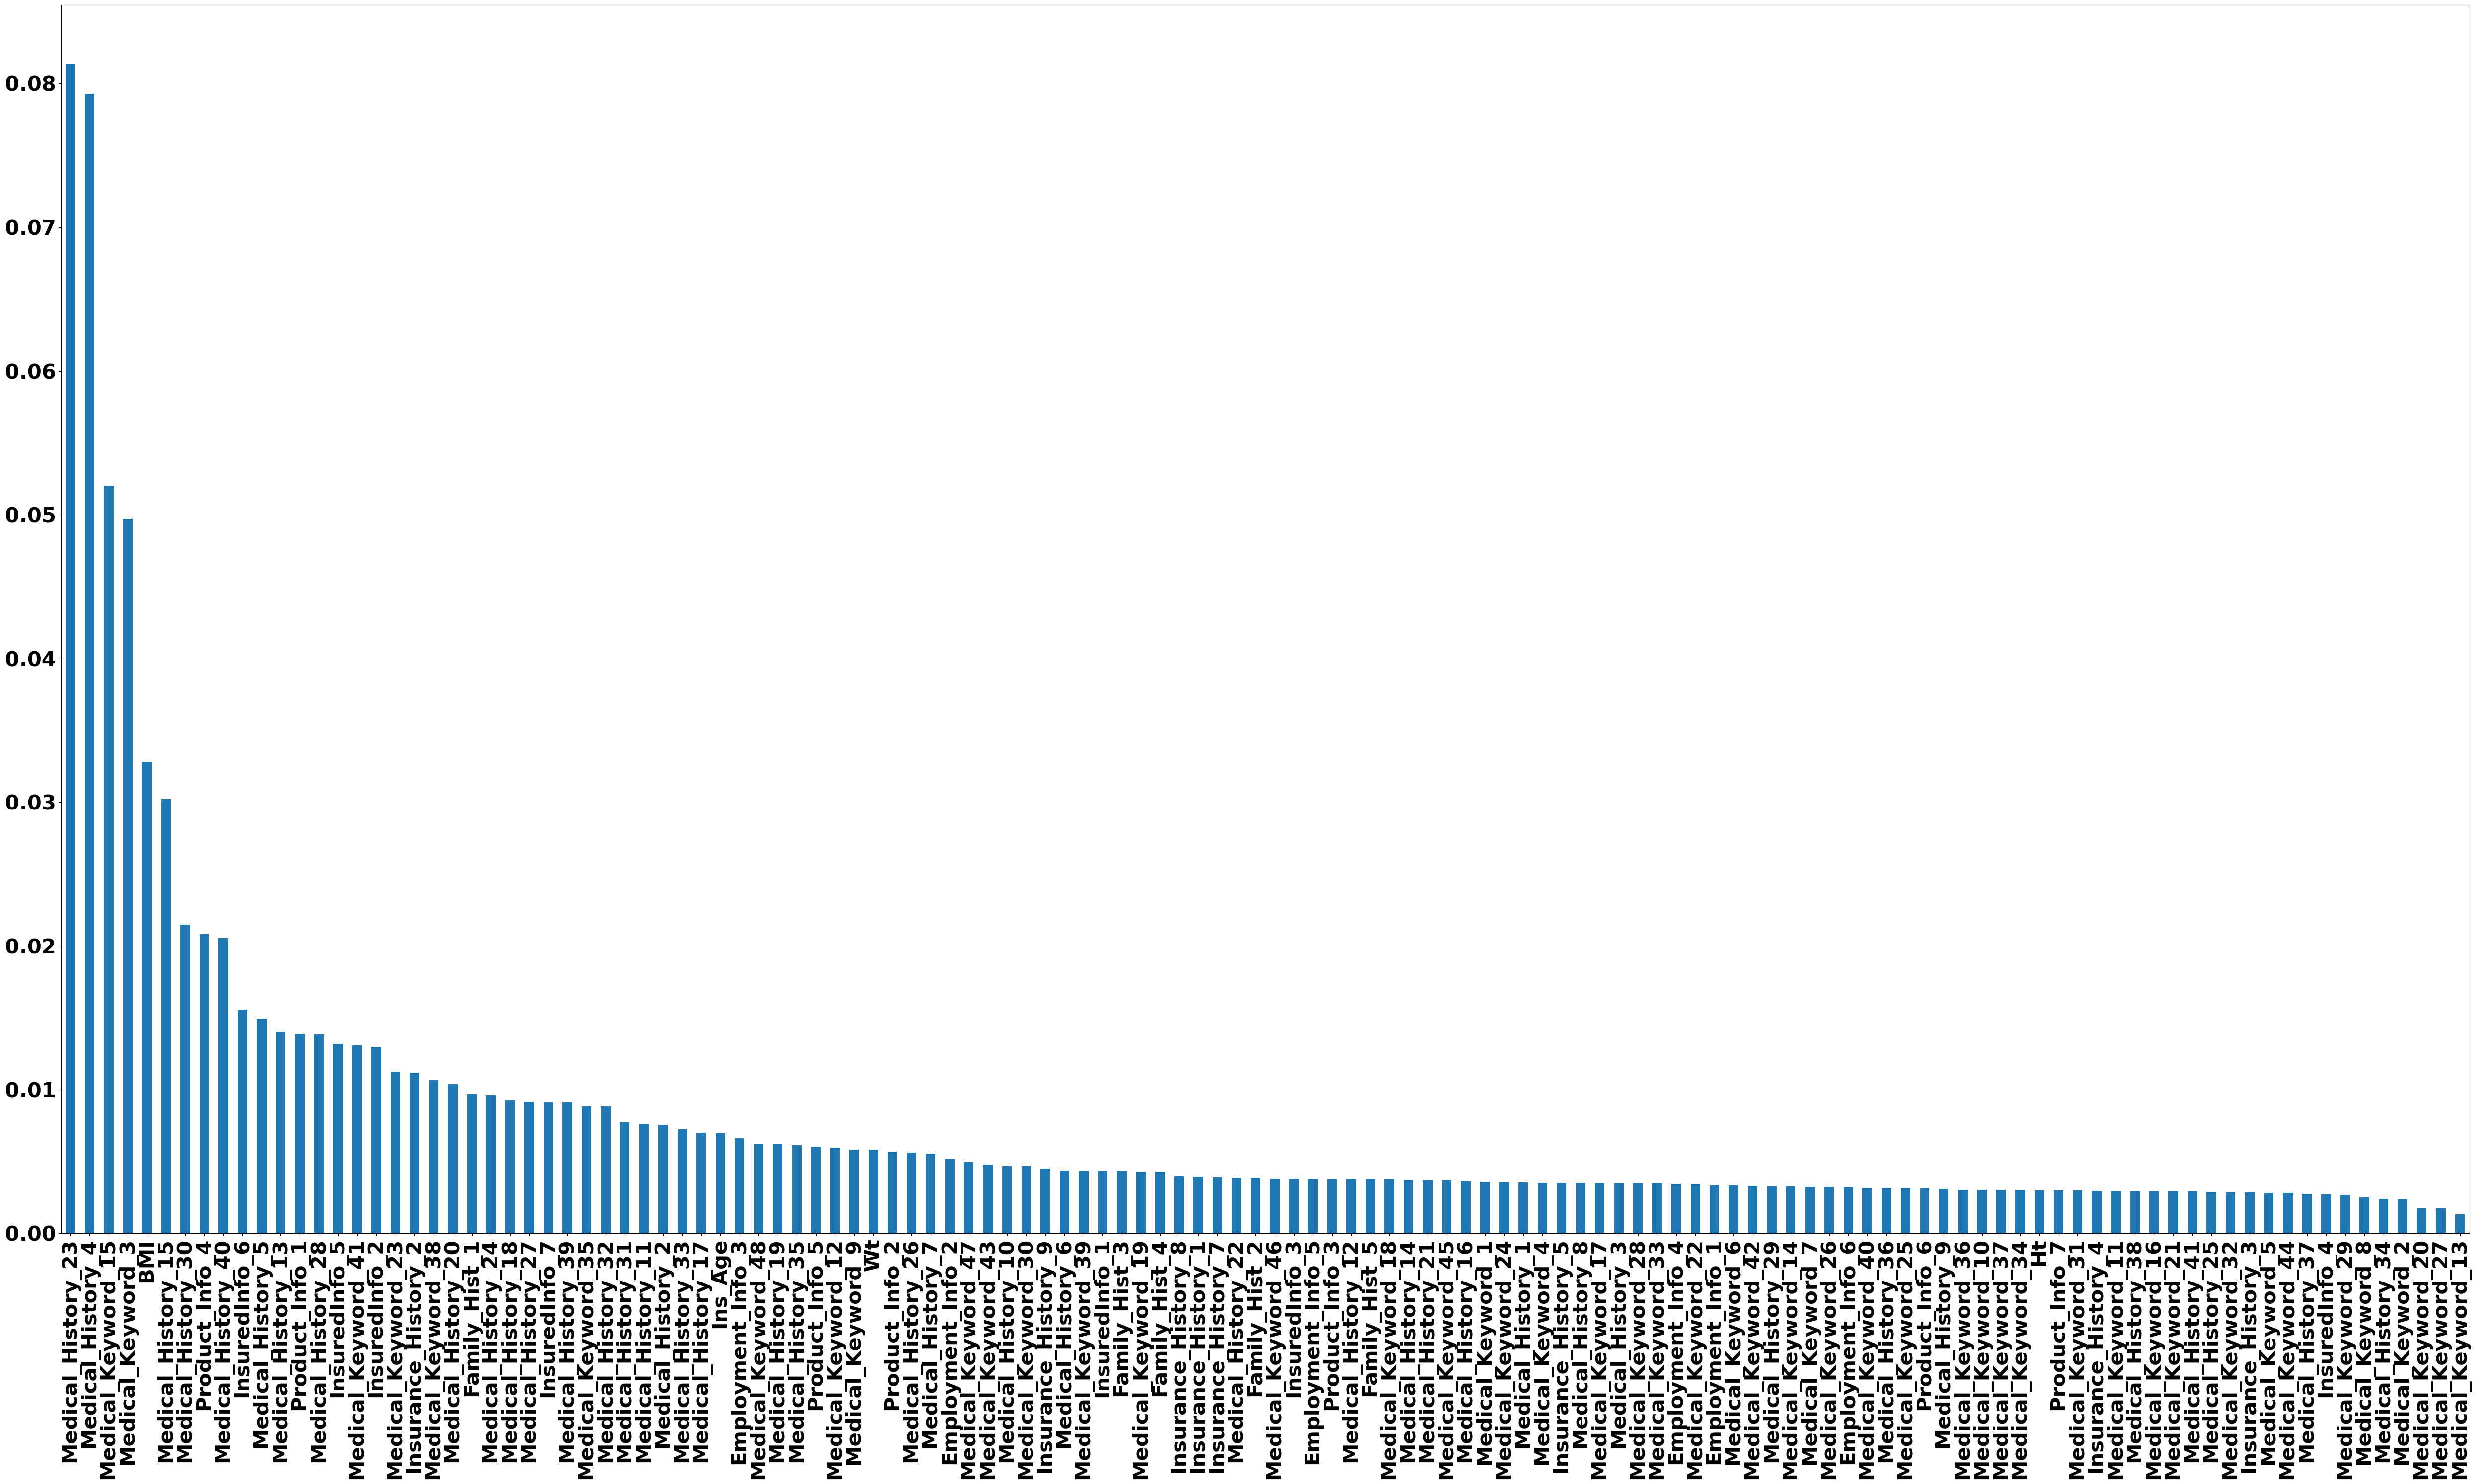

In [243]:
# get feature importance
importances = pd.Series(xgb_cl.feature_importances_, index=X_train_full.columns).sort_values(ascending=False)
plt.figure(figsize=(50,30 ))
ax=importances.plot(kind='bar')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=30, fontweight='bold')
ax.set_yticklabels(ax.get_yticklabels(),  fontsize=30, fontweight='bold')
plt.tight_layout()
plt.show()

In [244]:
#check the importances of the features we want to drop from EDA: 
importances[['Family_Hist_2', 'Family_Hist_3', 'Family_Hist_4', 'Family_Hist_5','Wt', 'Ht',
            'Product_Info_6','InsuredInfo_4','Insurance_History_1','Insurance_History_4',
             'Insurance_History_8', 'Medical_History_25', 'Medical_History_36']].sort_values()

InsuredInfo_4          0.002736
Medical_History_25     0.002899
Insurance_History_4    0.002991
Ht                     0.003026
Product_Info_6         0.003135
Medical_History_36     0.003172
Family_Hist_5          0.003765
Family_Hist_2          0.003857
Insurance_History_1    0.003939
Insurance_History_8    0.003963
Family_Hist_4          0.004287
Family_Hist_3          0.004308
Wt                     0.005791
dtype: float32

##### It seems Wt needs to be kept

In [38]:
#check the importances of the TBD features from EDA: Medical_History_10,Medical_History_15,Medical_History_24,
#Medical_History_32,Insurance_History_5
importances[['Medical_History_10','Medical_History_15','Medical_History_24','Medical_History_32','Insurance_History_5']].sort_values()

Insurance_History_5    0.003520
Medical_History_10     0.004677
Medical_History_32     0.008841
Medical_History_24     0.009611
Medical_History_15     0.030227
dtype: float32

##### it seems Medical_History10, Medical_History32, Medical_History_24, Medical_History15 need to be kept.

##### After the feature removal, the performance comparison is as below:
- Before: accuracy: 0.580634, f1: 0.507875    
- After: accuracy:  0.579792, f1: 0.507518      
          

##### It seems the feature removal doesnt degrade the model performance. Next, we can try to improve it by adding new interaction items base on the previous EDA. Based on the experiments, 
- adding Medical_History_10 + Medical_History_15: accuracy: 0.576986 f1: 0.503835     
- adding Employment_Info_1 + Employment_Info_6: accuracy: 0.577154 f1: 0.505970
- adding Medical_History_24 * Medical_History_32: accuracy: 0.577379 f1: 0.505509
- adding Ins_Age + Employment_Info_6 and Product_Info_4 + Employment_Info_1: accuracy: 0.575695 f1: 0.501917        
##### It seems adding new item is not helpful for further  improvement.

##### Thus, we just drop the 13 features directly.


### Chapter 4:  Model Tuning

In [247]:
# generate the new training dataset based on the analysis from feature engineering
X_train_full_copy=X_train_full.drop(['Family_Hist_2', 'Family_Hist_3', 'Family_Hist_4', 'Family_Hist_5', 'Insurance_History_5',
                                   'Product_Info_6','InsuredInfo_4','Insurance_History_1','Insurance_History_4',
             'Insurance_History_8', 'Medical_History_25', 'Medical_History_36', 'Ht' ], axis=1)

X_train_full_copy.shape

(59381, 113)

#### 4.1 XGBoost  Model Tuning without Data Preparation

In [246]:
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from scipy.stats import randint, uniform
from skopt import BayesSearchCV
from skopt.space import Real, Integer

In [252]:
# Random  tuning 

# Initialize the  XGBClassifier
xgb_cl = xgb.XGBClassifier(
    objective="multi:softmax",
    num_class=8,
    enable_categorical=True,
    random_state=123
)

# Define the StratifiedKFold 
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=2)

param_distributions = {
    'n_estimators': randint(50, 300),
    'max_depth': randint(2,10),
    'learning_rate': uniform(0.05, 0.3),
    'subsample': uniform(0.5,1),
    'colsample_bytree': uniform(0.5,1),
    'reg_alpha': uniform(0,1),
    'reg_lambda': uniform(0,1)
}



# Define the scoring metrics
scoring = {
    'accuracy': 'accuracy',
    'precision': make_scorer(precision_score, average='macro'),
    'recall': make_scorer(recall_score, average='macro'),
    'f1': make_scorer(f1_score, average='macro')
}

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(xgb_cl,
    param_distributions=param_distributions,
    n_iter=30,  # Number of parameter settings that are sampled
    scoring=scoring,
    refit='accuracy',                               
    cv=cv,  
    verbose=2,
    n_jobs=-1,  # Use all available cores
)

# Fit RandomSearchCV to the training data
random_search.fit(X_train_full_copy, y_train_full)
print(pd.DataFrame(random_search.cv_results_))
# Get the best model from Bayesian search
best_xgb_cl = random_search.best_estimator_
best_score = random_search.best_score_
print('best accuracy:', best_score)
print("Best hyperparameters found by random search:",random_search.best_params_)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


C:\Users\cclin\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
115 fits failed out of a total of 150.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\cclin\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\cclin\anaconda3\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "C:\Users\cclin\anaconda3\Lib\site-packages\xgboost\sklearn.py", line 1531, in fit
    self._Booster = train(
                    ^^^^^^
  File "C:\Users\cclin\

    mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       14.346917      1.179255         0.364569        0.073605   
1       66.599411      2.873988         2.209832        0.256895   
2        0.669294      0.031562         0.000000        0.000000   
3      114.643383      3.232124         3.016992        0.340697   
4        0.726897      0.028902         0.000000        0.000000   
5        0.731573      0.028970         0.000000        0.000000   
6      226.568908      2.843387         3.397689        0.264641   
7        1.235943      0.064388         0.000000        0.000000   
8        1.359937      0.092350         0.000000        0.000000   
9        1.227409      0.093096         0.000000        0.000000   
10       1.304359      0.081041         0.000000        0.000000   
11      84.115860      1.452195         2.312352        0.261465   
12       1.406403      0.156605         0.000000        0.000000   
13       1.323687      0.050914         0.000000

##### The best xgb model found from random search:
- best accuracy: 0.5884037980747594
- best f1: 0.517782
- Best hyperparameters found by random search: {'colsample_bytree': 0.9130975451061352, 'learning_rate': 0.057045652127873825, 'max_depth': 7, 'n_estimators': 215, 'reg_alpha': 0.9961095635154545, 'reg_lambda': 0.09010337373538357, 'subsample': 0.762233551182947}

#### 4.2 LightGBM  Model Tuning without Data Preparation

In [2]:
!pip install lightgbm

   ---------------------------------------- 0.0/1.4 MB ? eta -:--:--
    --------------------------------------- 0.0/1.4 MB 660.6 kB/s eta 0:00:03
   ----- ---------------------------------- 0.2/1.4 MB 2.4 MB/s eta 0:00:01
   -------------- ------------------------- 0.5/1.4 MB 4.2 MB/s eta 0:00:01
   -------------------------------- ------- 1.2/1.4 MB 6.8 MB/s eta 0:00:01
   ---------------------------------------- 1.4/1.4 MB 7.1 MB/s eta 0:00:00


In [43]:
from lightgbm import LGBMClassifier

In [257]:
# Random  tuning 

# Initialize the LGBMClassifier
lgbm_cl = LGBMClassifier(
    objective="multiclass",
    num_class=8,
    random_state=123
)


# Initialize RandomSearchCV
random_search = RandomizedSearchCV(
    estimator=lgbm_cl,
    param_distributions=param_distributions,
    n_iter=30,  # Number of iterations 
    scoring=scoring,
    refit='accuracy',
    cv=cv,  
    verbose=2,
    n_jobs=-1,  # Use all available cores
)

# Fit RandomSearchCV to the training data
random_search.fit(X_train_full_copy, y_train_full)
print(pd.DataFrame(random_search.cv_results_))
# Get the best model from Bayesian search
best_lgbm_cl = random_search.best_estimator_
best_score = random_search.best_score_
print('best accuracy:', best_score)
print("Best hyperparameters found by Random search:", random_search.best_params_)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


C:\Users\cclin\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
115 fits failed out of a total of 150.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
95 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\cclin\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\cclin\anaconda3\Lib\site-packages\lightgbm\sklearn.py", line 1284, in fit
    super().fit(
  File "C:\Users\cclin\anaconda3\Lib\site-packages\lightgbm\sklearn.py", line 955, in fit
    self._Booster = train(
                    ^^^^^^
  File "C:\Users\cclin\anaconda3\Lib\site-packages\light

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007718 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2709
[LightGBM] [Info] Number of data points in the train set: 59381, number of used features: 113
[LightGBM] [Info] Start training from score -2.258297
[LightGBM] [Info] Start training from score -2.204204
[LightGBM] [Info] Start training from score -4.071058
[LightGBM] [Info] Start training from score -3.727699
[LightGBM] [Info] Start training from score -2.391667
[LightGBM] [Info] Start training from score -1.665118
[LightGBM] [Info] Start training from score -2.001163
[LightGBM] [Info] Start training from

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

##### The lgbm best model found from Random search:
- best accuracy: 0.5864671502525904
- best f1: 0.508330 
- Best hyperparameters found by Random search: {'colsample_bytree': 0.7985851485780624, 'learning_rate': 0.12318449521925896, 'max_depth': 6, 'n_estimators': 53, 'reg_alpha': 0.07792546258722799, 'reg_lambda': 0.740812232869417, 'subsample': 0.8895583064870186}

#### 4.3 stacking XGBoost and LightGBM 

In [289]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

In [ ]:
# Bayes  tuning 

# Initialize the StackingClassifier
stacking_clf = StackingClassifier(
    estimators=[
        ('xgb', xgb_cl),
        ('lgbm', lgbm_cl),
    ],
    final_estimator=LogisticRegression(),
    cv=cv
)


search_spaces = {
    'xgb__n_estimators': Integer(50, 300),
    'xgb__max_depth': Integer(2, 10),
    'xgb__learning_rate': Real(0.01, 0.3, prior='uniform'),
    'xgb__subsample': Real(0.5, 1.0, prior='uniform'),
    'xgb__colsample_bytree': Real(0.5, 1.0, prior='uniform'),
    'xgb__reg_alpha': Real(0, 1, prior='uniform'),
    'xgb__reg_lambda': Real(0, 1, prior='uniform'),
    
    'lgbm__n_estimators': Integer(50, 300),
    'lgbm__max_depth': Integer(2, 10),
    'lgbm__learning_rate': Real(0.01, 0.3, prior='uniform'),
    'lgbm__subsample': Real(0.5, 1.0, prior='uniform'),
    'lgbm__colsample_bytree': Real(0.5, 1.0, prior='uniform'),
    'lgbm__reg_alpha': Real(0, 1, prior='uniform'),
    'lgbm__reg_lambda': Real(0, 1, prior='uniform'),
}


# Initialize BayesSearchCV
bayes_search = BayesSearchCV(
    estimator=stacking_clf,
    search_spaces=search_spaces,
    n_iter=30,  # Number of iterations 
    scoring=scoring,
    refit='accuracy',
    cv=cv,  
    verbose=1,
    n_jobs=-1,  # Use all available cores
)

# Fit BayesSearchCV to the training data
bayes_search.fit(X_train_full_copy, y_train_full)
print(pd.DataFrame(bayes_search.cv_results_))
# Get the best model from Bayesian search
best_stacking_clf = bayes_search.best_estimator_
best_score = bayes_search.best_score_
print('best accuracy:', best_score)
print("Best hyperparameters found by Bayesian search:", bayes_search.best_params_)

##### The best stacking model hyperparameters found by Bayesian search:
OrderedDict([('lgbm__colsample_bytree', 0.668657456956924), ('lgbm__learning_rate', 0.05937820267537357), ('lgbm__max_depth', 9), ('lgbm__n_estimators', 275), ('lgbm__reg_alpha', 0.7336943590168162), ('lgbm__reg_lambda', 0.9423816641922059), ('lgbm__subsample', 0.6058792598127403), ('xgb__colsample_bytree', 0.5185417798449724), ('xgb__learning_rate', 0.018388972097489596), ('xgb__max_depth', 9), ('xgb__n_estimators', 201), ('xgb__reg_alpha', 0.37426176330691857), ('xgb__reg_lambda', 0.37220283703154217), ('xgb__subsample', 0.9560488284287403)])
##### The best performace:
- accuracy: 0.5891279589634554
- f1: 0.518876 

##### we can see that stacking both lightgbm and xgboost doesnt improve the performance further, it achieves pretty close performance to the best xgboost alone. This might be from the significant similarity between both systems, or ~59% is already the best accuracy with the current setting.

#### 4.4 Other ML Models Tuning with Data Preparation

##### 4.4.1 LogisticRegression, DecisionTree, RandomForest Models Tuning

In [49]:
!pip install --upgrade scikit-learn

In [50]:
!pip install --upgrade imbalanced-learn


   ---------------------------------------- 0.0/258.3 kB ? eta -:--:--
   --- ----------------------------------- 20.5/258.3 kB 682.7 kB/s eta 0:00:01
   --------------- ------------------------ 102.4/258.3 kB 1.5 MB/s eta 0:00:01
   ---------------------------------------- 258.3/258.3 kB 2.3 MB/s eta 0:00:00
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.11.0
    Uninstalling imbalanced-learn-0.11.0:
      Successfully uninstalled imbalanced-learn-0.11.0


In [51]:
from sklearn.preprocessing import PowerTransformer, StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from category_encoders import TargetEncoder

In [258]:
# Definations

# training data
X_train_full_dp=X_train_full_copy.copy()
y_train_full_dp=y_train_full.copy()

# Define columns
numerical_columns = X_train_full_dp.select_dtypes(include=['number']).columns.tolist()
categorical_columns=X_train_full_dp.select_dtypes(include=['category']).columns.tolist()
#imputation columns
imp_constant_columns=['Medical_History_10', 'Medical_History_15', 'Medical_History_24', 'Medical_History_32']
imp_mode_columns=['Medical_History_1']
imp_median_columns=['Employment_Info_4', 'Employment_Info_6', 'Employment_Info_1']
#boxcox columns (standardize=True)
boxcox_numerical_columns = ['Product_Info_4','Wt', 'BMI','Employment_Info_1','Employment_Info_6'] 

#target encoding columns
target_cat_columns=imp_constant_columns+['Employment_Info_4']+categorical_columns


# define two bin_ranges
bin_ranges1= np.concatenate([[-2.0,-1.0], np.linspace(-0.5, 240, 120)])
bin_ranges2=np.linspace(-0.1,1,100)

# Define a binning function to convert numerical  features into categorical bins
def binning(x_series, bin_ranges):
    x_binned=pd.cut(x_series, bins=bin_ranges)
    return x_binned


# Define ML models   

#xgboost model
model=xgb.XGBClassifier(objective="multi:softmax", num_class=8, random_state=123)
param_distributions = {
    'n_estimators': randint(50, 300),
    'max_depth': randint(2,10),
    'learning_rate': uniform(0.05, 0.3),
    'subsample': uniform(0.5,1),
    'colsample_bytree': uniform(0.5,1),
    'reg_alpha': uniform(0,1),
    'reg_lambda': uniform(0,1)
}



# logistic regression
# model = LogisticRegression()
# param_distributions = {
#     'C': uniform(0.001, 100),  
#     'max_iter': [100, 200, 300]
# }


# # Decision Tree
# model = DecisionTreeClassifier(random_state=42)
# param_distributions = {
#     'max_depth': randint(10,200)
# }

##Random Forest
# model = RandomForestClassifier(random_state=42)
# param_distributions = {
#     'n_estimators': randint(100, 1000),
#     'max_depth': [3, 10, 20, 30, None],
# }


skf_inner = StratifiedKFold(n_splits=6, shuffle=True, random_state=10)


# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(model,
    param_distributions=param_distributions,
    n_iter=10,  # Number of parameter settings that are sampled
    scoring='accuracy', 
    cv=skf_inner,  
    verbose=2,
    n_jobs=-1,  # Use all available cores
)

skf_outer = StratifiedKFold(n_splits=7, shuffle=True, random_state=1)
results=[]

In [260]:
# Custom cross-validation with preprocessing
for train_index, val_index in skf_outer.split(X_train_full_dp, y_train_full_dp):
    X_train, X_val = X_train_full_dp.iloc[train_index], X_train_full_dp.iloc[val_index]
    y_train, y_val = y_train_full_dp.iloc[train_index], y_train_full_dp.iloc[val_index]   
    
    #step1: imputation

    # impute the four medical history features with heavy missing values by the constant -1 and 
    # add a binary indicator for each of them

    # add a binary indicator
    for col in imp_constant_columns:
        X_train[f'{col}_missing'] = X_train[col].isna().astype('int')
        X_val[f'{col}_missing'] = X_val[col].isna().astype('int')
    
    #constant imputation
    constant_imp=SimpleImputer(strategy='constant', fill_value=-1)
    X_train[imp_constant_columns]=constant_imp.fit_transform(X_train[imp_constant_columns])
    X_val[imp_constant_columns]=constant_imp.transform(X_val[imp_constant_columns])
    
   # median imputation 
    median_imp=SimpleImputer(strategy='median')
    X_train[imp_median_columns]=median_imp.fit_transform(X_train[imp_median_columns])
    X_val[imp_median_columns]=median_imp.transform(X_val[imp_median_columns])
   
  # mode imputation 
    mode_imp=SimpleImputer(strategy='most_frequent')
    X_train[imp_mode_columns]=mode_imp.fit_transform(X_train[imp_mode_columns])
    X_val[imp_mode_columns]=mode_imp.transform(X_val[imp_mode_columns])
 
    # step 2: box-cox transformation with standardize
    pt = PowerTransformer(method='yeo-johnson', standardize=True)
    X_train[boxcox_numerical_columns]=pt.fit_transform(X_train[boxcox_numerical_columns])
    X_val[boxcox_numerical_columns]=pt.transform(X_val[boxcox_numerical_columns])
    

    #step 3: apply binning function to imp_constant_columns and Employment_Info_4 which are highly skewed
    # that need to be binned for target encoding.
    for elem in imp_constant_columns:
        X_train[elem]=binning(X_train[elem], bin_ranges=bin_ranges1)
        X_val[elem]=binning(X_val[elem], bin_ranges=bin_ranges1)
    X_train['Employment_Info_4']=binning(X_train['Employment_Info_4'], bin_ranges=bin_ranges2)
    X_val['Employment_Info_4']=binning(X_val['Employment_Info_4'], bin_ranges=bin_ranges2)
  
    #step 4: apply target encoding 
    target_encoder=TargetEncoder(cols=target_cat_columns, smoothing=0,  return_df=True)
    X_train=target_encoder.fit_transform(X_train, y_train)
    X_val=target_encoder.transform(X_val)
    # Impute missing values in the encoded data
    imputer = SimpleImputer(strategy='mean')
    # Select only numeric columns
    encoded_numeric_cols = X_train.select_dtypes(include=[np.number]).columns
    # Apply SimpleImputer to numeric columns
    X_train[encoded_numeric_cols] = imputer.fit_transform(X_train[encoded_numeric_cols])
    X_val[encoded_numeric_cols] = imputer.transform(X_val[encoded_numeric_cols])

    
    #step 5: apply  SMOTE to handle imbalanced classes
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
    
    # step 6: Fit RandomSearchCV with inner cross-validation
  
    random_search.fit(X_train_resampled, y_train_resampled)

    # Predict and evaluate on the outer fold validation set
    val_preds = random_search.best_estimator_.predict(X_val)
    accuracy = accuracy_score(y_val, val_preds)
    f1=f1_score(y_val, val_preds, average='macro')
    precision=precision_score(y_val, val_preds, average='macro')
    recall=recall_score(y_val, val_preds, average='macro')
    results.append({
                    'best_params': random_search.best_params_,
                    'accuracy': accuracy,
                    'precision': precision,
                    'recall': recall,
                    'f1': f1
                   })
    
    print(results)

C:\Users\cclin\AppData\Local\Temp\ipykernel_25996\853982041.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[f'{col}_missing'] = X_train[col].isna().astype('int')
C:\Users\cclin\AppData\Local\Temp\ipykernel_25996\853982041.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val[f'{col}_missing'] = X_val[col].isna().astype('int')
C:\Users\cclin\AppData\Local\Temp\ipykernel_25996\853982041.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and wil

C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and wil

C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and wil

C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and wil

C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and wil

C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and wil

C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and wil

C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and wil

C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and wil

Fitting 6 folds for each of 10 candidates, totalling 60 fits


C:\Users\cclin\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
48 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
6 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\cclin\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\cclin\anaconda3\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "C:\Users\cclin\anaconda3\Lib\site-packages\xgboost\sklearn.py", line 1531, in fit
    self._Booster = train(
                    ^^^^^^
  File "C:\Users\cclin\an

[{'best_params': {'colsample_bytree': 0.6406774405117981, 'learning_rate': 0.3222362685375464, 'max_depth': 7, 'n_estimators': 62, 'reg_alpha': 0.9244900528191236, 'reg_lambda': 0.763688722540065, 'subsample': 0.594666483610281}, 'accuracy': 0.5863491689260875, 'precision': 0.5500818559700674, 'recall': 0.5132265960259801, 'f1': 0.5233894074420774}]


C:\Users\cclin\AppData\Local\Temp\ipykernel_25996\853982041.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[f'{col}_missing'] = X_train[col].isna().astype('int')
C:\Users\cclin\AppData\Local\Temp\ipykernel_25996\853982041.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val[f'{col}_missing'] = X_val[col].isna().astype('int')
C:\Users\cclin\AppData\Local\Temp\ipykernel_25996\853982041.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and wil

C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and wil

C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and wil

C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and wil

C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and wil

C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and wil

C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and wil

C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and wil

Fitting 6 folds for each of 10 candidates, totalling 60 fits


C:\Users\cclin\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
42 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
6 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\cclin\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\cclin\anaconda3\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "C:\Users\cclin\anaconda3\Lib\site-packages\xgboost\sklearn.py", line 1531, in fit
    self._Booster = train(
                    ^^^^^^
  File "C:\Users\cclin\an

[{'best_params': {'colsample_bytree': 0.6406774405117981, 'learning_rate': 0.3222362685375464, 'max_depth': 7, 'n_estimators': 62, 'reg_alpha': 0.9244900528191236, 'reg_lambda': 0.763688722540065, 'subsample': 0.594666483610281}, 'accuracy': 0.5863491689260875, 'precision': 0.5500818559700674, 'recall': 0.5132265960259801, 'f1': 0.5233894074420774}, {'best_params': {'colsample_bytree': 0.8593863077878924, 'learning_rate': 0.16209031187730583, 'max_depth': 5, 'n_estimators': 282, 'reg_alpha': 0.3787071808304897, 'reg_lambda': 0.47946832978420983, 'subsample': 0.8150062980621791}, 'accuracy': 0.5803371448779913, 'precision': 0.5351195747609516, 'recall': 0.5030567919635669, 'f1': 0.5121631695290721}]


C:\Users\cclin\AppData\Local\Temp\ipykernel_25996\853982041.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[f'{col}_missing'] = X_train[col].isna().astype('int')
C:\Users\cclin\AppData\Local\Temp\ipykernel_25996\853982041.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val[f'{col}_missing'] = X_val[col].isna().astype('int')
C:\Users\cclin\AppData\Local\Temp\ipykernel_25996\853982041.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and wil

C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and wil

C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and wil

C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and wil

C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and wil

C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and wil

C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and wil

C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and wil

C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and wil

Fitting 6 folds for each of 10 candidates, totalling 60 fits


C:\Users\cclin\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
48 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
6 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\cclin\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\cclin\anaconda3\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "C:\Users\cclin\anaconda3\Lib\site-packages\xgboost\sklearn.py", line 1531, in fit
    self._Booster = train(
                    ^^^^^^
  File "C:\Users\cclin\an

[{'best_params': {'colsample_bytree': 0.6406774405117981, 'learning_rate': 0.3222362685375464, 'max_depth': 7, 'n_estimators': 62, 'reg_alpha': 0.9244900528191236, 'reg_lambda': 0.763688722540065, 'subsample': 0.594666483610281}, 'accuracy': 0.5863491689260875, 'precision': 0.5500818559700674, 'recall': 0.5132265960259801, 'f1': 0.5233894074420774}, {'best_params': {'colsample_bytree': 0.8593863077878924, 'learning_rate': 0.16209031187730583, 'max_depth': 5, 'n_estimators': 282, 'reg_alpha': 0.3787071808304897, 'reg_lambda': 0.47946832978420983, 'subsample': 0.8150062980621791}, 'accuracy': 0.5803371448779913, 'precision': 0.5351195747609516, 'recall': 0.5030567919635669, 'f1': 0.5121631695290721}, {'best_params': {'colsample_bytree': 0.8047246647175633, 'learning_rate': 0.32059960689772843, 'max_depth': 2, 'n_estimators': 220, 'reg_alpha': 0.3293896550560499, 'reg_lambda': 0.4743971254834891, 'subsample': 0.8017705657644054}, 'accuracy': 0.581515973122716, 'precision': 0.5358189055823

C:\Users\cclin\AppData\Local\Temp\ipykernel_25996\853982041.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[f'{col}_missing'] = X_train[col].isna().astype('int')
C:\Users\cclin\AppData\Local\Temp\ipykernel_25996\853982041.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val[f'{col}_missing'] = X_val[col].isna().astype('int')
C:\Users\cclin\AppData\Local\Temp\ipykernel_25996\853982041.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and wil

C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and wil

C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and wil

C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and wil

C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and wil

C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and wil

C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and wil

C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and wil

C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and wil

C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and wil

Fitting 6 folds for each of 10 candidates, totalling 60 fits


C:\Users\cclin\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
36 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
6 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\cclin\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\cclin\anaconda3\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "C:\Users\cclin\anaconda3\Lib\site-packages\xgboost\sklearn.py", line 1531, in fit
    self._Booster = train(
                    ^^^^^^
  File "C:\Users\cclin\an

[{'best_params': {'colsample_bytree': 0.6406774405117981, 'learning_rate': 0.3222362685375464, 'max_depth': 7, 'n_estimators': 62, 'reg_alpha': 0.9244900528191236, 'reg_lambda': 0.763688722540065, 'subsample': 0.594666483610281}, 'accuracy': 0.5863491689260875, 'precision': 0.5500818559700674, 'recall': 0.5132265960259801, 'f1': 0.5233894074420774}, {'best_params': {'colsample_bytree': 0.8593863077878924, 'learning_rate': 0.16209031187730583, 'max_depth': 5, 'n_estimators': 282, 'reg_alpha': 0.3787071808304897, 'reg_lambda': 0.47946832978420983, 'subsample': 0.8150062980621791}, 'accuracy': 0.5803371448779913, 'precision': 0.5351195747609516, 'recall': 0.5030567919635669, 'f1': 0.5121631695290721}, {'best_params': {'colsample_bytree': 0.8047246647175633, 'learning_rate': 0.32059960689772843, 'max_depth': 2, 'n_estimators': 220, 'reg_alpha': 0.3293896550560499, 'reg_lambda': 0.4743971254834891, 'subsample': 0.8017705657644054}, 'accuracy': 0.581515973122716, 'precision': 0.5358189055823

C:\Users\cclin\AppData\Local\Temp\ipykernel_25996\853982041.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[f'{col}_missing'] = X_train[col].isna().astype('int')
C:\Users\cclin\AppData\Local\Temp\ipykernel_25996\853982041.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val[f'{col}_missing'] = X_val[col].isna().astype('int')
C:\Users\cclin\AppData\Local\Temp\ipykernel_25996\853982041.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and wil

C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and wil

C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and wil

C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and wil

C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and wil

C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and wil

C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and wil

C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and wil

Fitting 6 folds for each of 10 candidates, totalling 60 fits


C:\Users\cclin\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
42 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
6 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\cclin\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\cclin\anaconda3\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "C:\Users\cclin\anaconda3\Lib\site-packages\xgboost\sklearn.py", line 1531, in fit
    self._Booster = train(
                    ^^^^^^
  File "C:\Users\cclin\an

[{'best_params': {'colsample_bytree': 0.6406774405117981, 'learning_rate': 0.3222362685375464, 'max_depth': 7, 'n_estimators': 62, 'reg_alpha': 0.9244900528191236, 'reg_lambda': 0.763688722540065, 'subsample': 0.594666483610281}, 'accuracy': 0.5863491689260875, 'precision': 0.5500818559700674, 'recall': 0.5132265960259801, 'f1': 0.5233894074420774}, {'best_params': {'colsample_bytree': 0.8593863077878924, 'learning_rate': 0.16209031187730583, 'max_depth': 5, 'n_estimators': 282, 'reg_alpha': 0.3787071808304897, 'reg_lambda': 0.47946832978420983, 'subsample': 0.8150062980621791}, 'accuracy': 0.5803371448779913, 'precision': 0.5351195747609516, 'recall': 0.5030567919635669, 'f1': 0.5121631695290721}, {'best_params': {'colsample_bytree': 0.8047246647175633, 'learning_rate': 0.32059960689772843, 'max_depth': 2, 'n_estimators': 220, 'reg_alpha': 0.3293896550560499, 'reg_lambda': 0.4743971254834891, 'subsample': 0.8017705657644054}, 'accuracy': 0.581515973122716, 'precision': 0.5358189055823

C:\Users\cclin\AppData\Local\Temp\ipykernel_25996\853982041.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[f'{col}_missing'] = X_train[col].isna().astype('int')
C:\Users\cclin\AppData\Local\Temp\ipykernel_25996\853982041.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val[f'{col}_missing'] = X_val[col].isna().astype('int')
C:\Users\cclin\AppData\Local\Temp\ipykernel_25996\853982041.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and wil

C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and wil

C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and wil

C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and wil

C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and wil

C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and wil

C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and wil

C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and wil

C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and wil

C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)


Fitting 6 folds for each of 10 candidates, totalling 60 fits


C:\Users\cclin\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
30 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
6 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\cclin\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\cclin\anaconda3\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "C:\Users\cclin\anaconda3\Lib\site-packages\xgboost\sklearn.py", line 1531, in fit
    self._Booster = train(
                    ^^^^^^
  File "C:\Users\cclin\an

[{'best_params': {'colsample_bytree': 0.6406774405117981, 'learning_rate': 0.3222362685375464, 'max_depth': 7, 'n_estimators': 62, 'reg_alpha': 0.9244900528191236, 'reg_lambda': 0.763688722540065, 'subsample': 0.594666483610281}, 'accuracy': 0.5863491689260875, 'precision': 0.5500818559700674, 'recall': 0.5132265960259801, 'f1': 0.5233894074420774}, {'best_params': {'colsample_bytree': 0.8593863077878924, 'learning_rate': 0.16209031187730583, 'max_depth': 5, 'n_estimators': 282, 'reg_alpha': 0.3787071808304897, 'reg_lambda': 0.47946832978420983, 'subsample': 0.8150062980621791}, 'accuracy': 0.5803371448779913, 'precision': 0.5351195747609516, 'recall': 0.5030567919635669, 'f1': 0.5121631695290721}, {'best_params': {'colsample_bytree': 0.8047246647175633, 'learning_rate': 0.32059960689772843, 'max_depth': 2, 'n_estimators': 220, 'reg_alpha': 0.3293896550560499, 'reg_lambda': 0.4743971254834891, 'subsample': 0.8017705657644054}, 'accuracy': 0.581515973122716, 'precision': 0.5358189055823

C:\Users\cclin\AppData\Local\Temp\ipykernel_25996\853982041.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[f'{col}_missing'] = X_train[col].isna().astype('int')
C:\Users\cclin\AppData\Local\Temp\ipykernel_25996\853982041.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val[f'{col}_missing'] = X_val[col].isna().astype('int')
C:\Users\cclin\AppData\Local\Temp\ipykernel_25996\853982041.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and wil

C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and wil

C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and wil

C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and wil

C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and wil

C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and wil

C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and wil

C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and wil

C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and wil

C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and wil

Fitting 6 folds for each of 10 candidates, totalling 60 fits


C:\Users\cclin\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
48 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
6 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\cclin\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\cclin\anaconda3\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "C:\Users\cclin\anaconda3\Lib\site-packages\xgboost\sklearn.py", line 1531, in fit
    self._Booster = train(
                    ^^^^^^
  File "C:\Users\cclin\an

[{'best_params': {'colsample_bytree': 0.6406774405117981, 'learning_rate': 0.3222362685375464, 'max_depth': 7, 'n_estimators': 62, 'reg_alpha': 0.9244900528191236, 'reg_lambda': 0.763688722540065, 'subsample': 0.594666483610281}, 'accuracy': 0.5863491689260875, 'precision': 0.5500818559700674, 'recall': 0.5132265960259801, 'f1': 0.5233894074420774}, {'best_params': {'colsample_bytree': 0.8593863077878924, 'learning_rate': 0.16209031187730583, 'max_depth': 5, 'n_estimators': 282, 'reg_alpha': 0.3787071808304897, 'reg_lambda': 0.47946832978420983, 'subsample': 0.8150062980621791}, 'accuracy': 0.5803371448779913, 'precision': 0.5351195747609516, 'recall': 0.5030567919635669, 'f1': 0.5121631695290721}, {'best_params': {'colsample_bytree': 0.8047246647175633, 'learning_rate': 0.32059960689772843, 'max_depth': 2, 'n_estimators': 220, 'reg_alpha': 0.3293896550560499, 'reg_lambda': 0.4743971254834891, 'subsample': 0.8017705657644054}, 'accuracy': 0.581515973122716, 'precision': 0.5358189055823

##### By random searching, the best performance achieved by each model with data preparation is as below:
- XGBoost:
   - 'best_params': {'colsample_bytree': 0.6406774405117981, 'learning_rate': 0.3222362685375464, 'max_depth': 7, 'n_estimators': 62, 'reg_alpha': 0.9244900528191236, 'reg_lambda': 0.763688722540065, 'subsample': 0.594666483610281}
   - 'accuracy': 0.5863491689260875
   - 'precision': 0.5500818559700674
   - 'recall': 0.5132265960259801
   - 'f1': 0.5233894074420774}


- Logistic Regression:
   - 'best_params': {'C': 45.99940466735602, 'max_iter': 300}
   - 'accuracy': 0.48131557232111283
   - 'precision': 0.4193567256832097
   - 'recall': 0.4642504640485058
   - 'f1': 0.4317924866311434
   
- Decision Tree:
   - 'best_params': {'max_depth': 26},
   - 'accuracy': 0.4717670635388424
   - 'precision': 0.40010846788504495
   - 'recall': 0.4205984482773357
   - 'f1': 0.4089527419151905

- Random Forest 
   - 'best_params': {'max_depth': None, 'n_estimators': 247}
   - 'accuracy': 0.5699634563244136
   - 'precision': 0.5156539009553092
   - 'recall': 0.5028656899602578
   - 'f1': 0.4983503446586156
   
The best performance is still from xgboost.

##### 4.4.2 Neural Network

In [25]:
!pip install tensorflow

In [53]:
import tensorflow as tf 
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.optimizers import Adam

In [261]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full_dp, y_train_full_dp, 
    test_size=0.15,  # Adjust the proportion as needed
    stratify=y_train_full_dp,  # Ensure class distribution is preserved
    random_state=1360
)

In [292]:
# step 1: imputation

#add a binary indicator
for col in imp_constant_columns:
    X_train[f'{col}_missing'] = X_train[col].isna().astype('int')
    X_val[f'{col}_missing'] = X_val[col].isna().astype('int')

#constant imputation
constant_imp=SimpleImputer(strategy='constant', fill_value=-1)
X_train[imp_constant_columns]=constant_imp.fit_transform(X_train[imp_constant_columns])
#Transform validation data
X_val[imp_constant_columns]=constant_imp.transform(X_val[imp_constant_columns])

#median imputation 
median_imp=SimpleImputer(strategy='median')
X_train[imp_median_columns]=median_imp.fit_transform(X_train[imp_median_columns])
X_val[imp_median_columns]=median_imp.transform(X_val[imp_median_columns])


#mode imputation 
mode_imp=SimpleImputer(strategy='most_frequent')
X_train[imp_mode_columns]=mode_imp.fit_transform(X_train[imp_mode_columns])
X_val[imp_mode_columns]=mode_imp.transform(X_val[imp_mode_columns])

#step 2: box-cox transformation with standarize
pt = PowerTransformer(method='yeo-johnson', standardize=True)
X_train[boxcox_numerical_columns]=pt.fit_transform(X_train[boxcox_numerical_columns])
X_val[boxcox_numerical_columns]=pt.transform(X_val[boxcox_numerical_columns])

#step 3: apply binning function to imp_constant_columns and Employment_Info_4 
for elem in imp_constant_columns:
    X_train[elem]=binning(X_train[elem], bin_ranges=bin_ranges1)
    X_val[elem]=binning(X_val[elem], bin_ranges=bin_ranges1)
X_train['Employment_Info_4']=binning(X_train['Employment_Info_4'], bin_ranges=bin_ranges2)
X_val['Employment_Info_4']=binning(X_val['Employment_Info_4'], bin_ranges=bin_ranges2)

#step 4: apply target encoding 
target_encoder=TargetEncoder(cols=target_cat_columns, smoothing=0,   return_df=True)
X_train=target_encoder.fit_transform(X_train, y_train)
X_val=target_encoder.transform(X_val)
#Impute missing values in the encoded data
imputer = SimpleImputer(strategy='mean')
# Select only numeric columns
encoded_numeric_cols = X_train.select_dtypes(include=[np.number]).columns
# Apply SimpleImputer to numeric columns
X_train[encoded_numeric_cols] = imputer.fit_transform(X_train[encoded_numeric_cols])
X_val[encoded_numeric_cols] = imputer.transform(X_val[encoded_numeric_cols])

#step 5: apply  SMOTE to handle imbalanced classes
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)


C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and wil

C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and wil

C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and wil

C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and wil

C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and wil

C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and wil

C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and wil

C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and wil

C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and wil

In [293]:
X_train_resampled.shape

(132520, 117)

In [298]:
#Define the Custom Metric for F1 (Macro)
class F1Macro(tf.keras.callbacks.Callback):
    def __init__(self, validation_data):
        super(F1Macro, self).__init__()
        self.validation_data = validation_data

    def on_epoch_end(self, epoch, logs=None):
        val_data, val_labels = self.validation_data
        y_pred = np.argmax(self.model.predict(val_data), axis=-1)
        y_true = val_labels
        f1 = f1_score(y_true, y_pred, average='macro')
        print(f"\nEpoch {epoch + 1}: val_f1_macro: {f1:.4f}")
        logs['val_f1_macro'] = f1


Epoch 1/200
279/279 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step   accuracy: 0.1263 - l

Epoch 1: val_f1_macro: 0.1303
130/130 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.1272 - loss: 2.2206 - val_accuracy: 0.3115 - val_loss: 2.0308 - val_f1_macro: 0.1303
Epoch 2/200
279/279 ━━━━━━━━━━━━━━━━━━━━ 0s 870us/step accuracy: 0.1961 - los

Epoch 2: val_f1_macro: 0.1675
130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.1968 - loss: 2.0423 - val_accuracy: 0.2626 - val_loss: 1.9783 - val_f1_macro: 0.1675
Epoch 3/200
279/279 ━━━━━━━━━━━━━━━━━━━━ 0s 920us/step accuracy: 0.2593 - l

Epoch 3: val_f1_macro: 0.2178
130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.2605 - loss: 1.9507 - val_accuracy: 0.2993 - val_loss: 1.8451 - val_f1_macro: 0.2178
Epoch 4/200
279/279 ━━━━━━━━━━━━━━━━━━━━ 0s 930us/step accuracy: 0.3309 - l

Epoch 4: val_f1_macro: 0.2631
130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.3316 - loss: 1.8137 - val_accuracy: 0.3611 - val_loss: 1.7377 - val_f1_macro: 0.2631
Epoch 5/20

Epoch 27/200
279/279 ━━━━━━━━━━━━━━━━━━━━ 0s 936us/step accuracy: 0.4513 - l

Epoch 27: val_f1_macro: 0.3743
130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.4514 - loss: 1.4411 - val_accuracy: 0.4306 - val_loss: 1.5297 - val_f1_macro: 0.3743
Epoch 28/200
279/279 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4540 - l

Epoch 28: val_f1_macro: 0.3899
130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.4539 - loss: 1.4328 - val_accuracy: 0.4601 - val_loss: 1.4898 - val_f1_macro: 0.3899
Epoch 29/200
279/279 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step accuracy: 0.4572 - l

Epoch 29: val_f1_macro: 0.3884
130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.4570 - loss: 1.4284 - val_accuracy: 0.4542 - val_loss: 1.4813 - val_f1_macro: 0.3884
Epoch 30/200
279/279 ━━━━━━━━━━━━━━━━━━━━ 0s 846us/step accuracy: 0.4560 - los

Epoch 30: val_f1_macro: 0.3925
130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4564 - loss: 1.4278 - val_accuracy: 0.4727 - val_loss: 1.4492 - val_f1_macro: 0.3925
Ep

Epoch 53/200
279/279 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step   accuracy: 0.4878 - l

Epoch 53: val_f1_macro: 0.4182
130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.4878 - loss: 1.3621 - val_accuracy: 0.4810 - val_loss: 1.4258 - val_f1_macro: 0.4182
Epoch 54/200
279/279 ━━━━━━━━━━━━━━━━━━━━ 0s 782us/step accuracy: 0.4868 - los

Epoch 54: val_f1_macro: 0.4154
130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4869 - loss: 1.3611 - val_accuracy: 0.4789 - val_loss: 1.4349 - val_f1_macro: 0.4154
Epoch 55/200
279/279 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step accuracy: 0.4860 - los

Epoch 55: val_f1_macro: 0.4217
130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4861 - loss: 1.3649 - val_accuracy: 0.4838 - val_loss: 1.4352 - val_f1_macro: 0.4217
Epoch 56/200
279/279 ━━━━━━━━━━━━━━━━━━━━ 0s 732us/step accuracy: 0.4872 - los

Epoch 56: val_f1_macro: 0.4242
130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.4873 - loss: 1.3618 - val_accuracy: 0.4935 - val_loss: 1.4258 - val_f1_macro: 0.424

Epoch 79/200
279/279 ━━━━━━━━━━━━━━━━━━━━ 0s 854us/step accuracy: 0.4995 - los

Epoch 79: val_f1_macro: 0.4315
130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4995 - loss: 1.3325 - val_accuracy: 0.5008 - val_loss: 1.4023 - val_f1_macro: 0.4315
Epoch 80/200
279/279 ━━━━━━━━━━━━━━━━━━━━ 0s 866us/step accuracy: 0.5007 - los

Epoch 80: val_f1_macro: 0.4334
130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5007 - loss: 1.3314 - val_accuracy: 0.4965 - val_loss: 1.4112 - val_f1_macro: 0.4334
Epoch 81/200
279/279 ━━━━━━━━━━━━━━━━━━━━ 0s 843us/step accuracy: 0.4994 - los

Epoch 81: val_f1_macro: 0.4341
130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4995 - loss: 1.3318 - val_accuracy: 0.4996 - val_loss: 1.4225 - val_f1_macro: 0.4341
Epoch 82/200
279/279 ━━━━━━━━━━━━━━━━━━━━ 0s 813us/step accuracy: 0.4995 - los

Epoch 82: val_f1_macro: 0.4286
130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4995 - loss: 1.3348 - val_accuracy: 0.4888 - val_loss: 1.4270 - val_f1_macro: 0.4

Epoch 105/200
279/279 ━━━━━━━━━━━━━━━━━━━━ 0s 774us/step accuracy: 0.5068 - los

Epoch 105: val_f1_macro: 0.4330
130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5070 - loss: 1.3123 - val_accuracy: 0.5057 - val_loss: 1.3899 - val_f1_macro: 0.4330
Epoch 106/200
279/279 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5069 - l

Epoch 106: val_f1_macro: 0.4412
130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5070 - loss: 1.3170 - val_accuracy: 0.5052 - val_loss: 1.4002 - val_f1_macro: 0.4412
Epoch 107/200
279/279 ━━━━━━━━━━━━━━━━━━━━ 0s 939us/step accuracy: 0.5093 - l

Epoch 107: val_f1_macro: 0.4386
130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5092 - loss: 1.3101 - val_accuracy: 0.4974 - val_loss: 1.4237 - val_f1_macro: 0.4386
Epoch 108/200
279/279 ━━━━━━━━━━━━━━━━━━━━ 0s 940us/step accuracy: 0.5113 - l

Epoch 108: val_f1_macro: 0.4454
130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5113 - loss: 1.3045 - val_accuracy: 0.5074 - val_loss: 1.4041 - val_f1_macro: 0

Epoch 131/200
279/279 ━━━━━━━━━━━━━━━━━━━━ 0s 843us/step accuracy: 0.5153 - los

Epoch 131: val_f1_macro: 0.4469
130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5151 - loss: 1.2961 - val_accuracy: 0.5128 - val_loss: 1.3864 - val_f1_macro: 0.4469
Epoch 132/200
279/279 ━━━━━━━━━━━━━━━━━━━━ 0s 820us/step accuracy: 0.5161 - los

Epoch 132: val_f1_macro: 0.4508
130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5156 - loss: 1.2909 - val_accuracy: 0.5122 - val_loss: 1.3844 - val_f1_macro: 0.4508
Epoch 133/200
279/279 ━━━━━━━━━━━━━━━━━━━━ 0s 834us/step accuracy: 0.5102 - los

Epoch 133: val_f1_macro: 0.4439
130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5108 - loss: 1.3033 - val_accuracy: 0.5001 - val_loss: 1.4103 - val_f1_macro: 0.4439
Epoch 134/200
279/279 ━━━━━━━━━━━━━━━━━━━━ 0s 916us/step accuracy: 0.5165 - l

Epoch 134: val_f1_macro: 0.4439
130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5165 - loss: 1.2918 - val_accuracy: 0.5066 - val_loss: 1.3908 - val_f1_macr

Epoch 157/200
279/279 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step   accuracy: 0.5195 - l

Epoch 157: val_f1_macro: 0.4463
130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5196 - loss: 1.2848 - val_accuracy: 0.5057 - val_loss: 1.3936 - val_f1_macro: 0.4463
Epoch 158/200
279/279 ━━━━━━━━━━━━━━━━━━━━ 0s 859us/step accuracy: 0.5224 - los

Epoch 158: val_f1_macro: 0.4536
130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5221 - loss: 1.2807 - val_accuracy: 0.5194 - val_loss: 1.3649 - val_f1_macro: 0.4536
Epoch 159/200
279/279 ━━━━━━━━━━━━━━━━━━━━ 0s 893us/step accuracy: 0.5204 - los

Epoch 159: val_f1_macro: 0.4434
130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5204 - loss: 1.2856 - val_accuracy: 0.5165 - val_loss: 1.3759 - val_f1_macro: 0.4434
Epoch 160/200
279/279 ━━━━━━━━━━━━━━━━━━━━ 0s 816us/step accuracy: 0.5199 - los

Epoch 160: val_f1_macro: 0.4465
130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5199 - loss: 1.2833 - val_accuracy: 0.5034 - val_loss: 1.3975 - val_f1_macr

Epoch 183/200
279/279 ━━━━━━━━━━━━━━━━━━━━ 0s 843us/step accuracy: 0.5243 - los

Epoch 183: val_f1_macro: 0.4476
130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5245 - loss: 1.2774 - val_accuracy: 0.5082 - val_loss: 1.3955 - val_f1_macro: 0.4476
Epoch 184/200
279/279 ━━━━━━━━━━━━━━━━━━━━ 0s 818us/step accuracy: 0.5232 - los

Epoch 184: val_f1_macro: 0.4470
130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5233 - loss: 1.2739 - val_accuracy: 0.4945 - val_loss: 1.4307 - val_f1_macro: 0.4470
Epoch 185/200
279/279 ━━━━━━━━━━━━━━━━━━━━ 0s 900us/step accuracy: 0.5251 - los

Epoch 185: val_f1_macro: 0.4495
130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5251 - loss: 1.2706 - val_accuracy: 0.5074 - val_loss: 1.3970 - val_f1_macro: 0.4495
Epoch 186/200
279/279 ━━━━━━━━━━━━━━━━━━━━ 0s 794us/step accuracy: 0.5236 - los

Epoch 186: val_f1_macro: 0.4507
130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5236 - loss: 1.2727 - val_accuracy: 0.5106 - val_loss: 1.3901 - val_f1_ma

<Axes: >

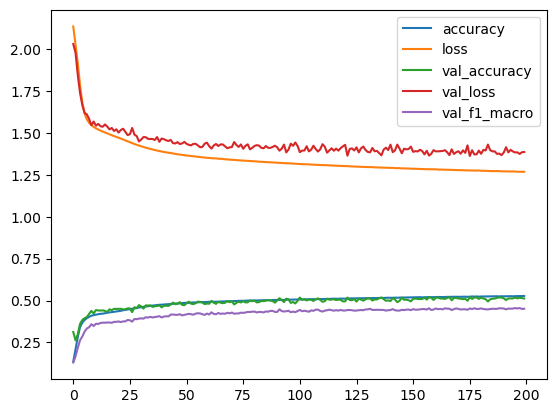

In [300]:
#step 6 NN training
model = Sequential ()
model.add(Dense(32, input_shape=(117,),activation='relu')) 
model.add(Dense(32,activation='relu'))
model.add(Dense(32,activation='relu'))
model.add(Dense(32,activation='relu'))
model.add(Dense(8,activation='softmax')) 
model.compile(loss='SparseCategoricalCrossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

# Define the F1 Macro callback with validation data
f1_macro_callback = F1Macro(validation_data=(X_val, y_val))

history = model.fit(X_train_resampled, y_train_resampled, 
                    epochs=200, 
                    batch_size=1024, 
                    validation_data=(X_val, y_val),
                    callbacks=[f1_macro_callback])

pd.DataFrame(history.history).plot()

##### after model tuning, the current architecture works best that validation accuaracy achieves 52% at around 150 epochs.

##### In summary, Xgboost works best and achieves pretty similar performance with and without data preparation. In the following, I will use Xgboost model to do interpretation by LIME.

### Chapter 5: Model Interpretation

In [58]:
!pip install lime

In [ ]:
from lime.lime_tabular import LimeTabularExplainer 
from imblearn.over_sampling import ADASYN
from sklearn.utils.class_weight import compute_class_weight

In [301]:
# data preparation before fitting with the best xgb model

#split training data
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full_dp, y_train_full_dp, 
    test_size=0.15,  # Adjust the proportion as needed
    stratify=y_train_full_dp,  # Ensure class distribution is preserved
    random_state=1240
)
# step 1: imputation
#add a binary indicator
for col in imp_constant_columns:
    X_train[f'{col}_missing'] = X_train[col].isna().astype('int')
    X_val[f'{col}_missing'] = X_val[col].isna().astype('int')
#constant imputation
constant_imp=SimpleImputer(strategy='constant', fill_value=-1)
X_train[imp_constant_columns]=constant_imp.fit_transform(X_train[imp_constant_columns])
#Transform validation data
X_val[imp_constant_columns]=constant_imp.transform(X_val[imp_constant_columns])
#median imputation 
median_imp=SimpleImputer(strategy='median')
X_train[imp_median_columns]=median_imp.fit_transform(X_train[imp_median_columns])
X_val[imp_median_columns]=median_imp.transform(X_val[imp_median_columns])
#mode imputation 
mode_imp=SimpleImputer(strategy='most_frequent')
X_train[imp_mode_columns]=mode_imp.fit_transform(X_train[imp_mode_columns])
X_val[imp_mode_columns]=mode_imp.transform(X_val[imp_mode_columns])

#step 2: box-cox transformation with standardize
pt = PowerTransformer(method='yeo-johnson', standardize=True)
X_train[boxcox_numerical_columns]=pt.fit_transform(X_train[boxcox_numerical_columns])
X_val[boxcox_numerical_columns]=pt.transform(X_val[boxcox_numerical_columns])


#step 3: apply binning function to imp_constant_columns and Employment_Info_4 
for elem in imp_constant_columns:
    X_train[elem]=binning(X_train[elem], bin_ranges=bin_ranges1)
    X_val[elem]=binning(X_val[elem], bin_ranges=bin_ranges1)
X_train['Employment_Info_4']=binning(X_train['Employment_Info_4'], bin_ranges=bin_ranges2)
X_val['Employment_Info_4']=binning(X_val['Employment_Info_4'], bin_ranges=bin_ranges2)

#step 4: apply target encoding 
target_encoder=TargetEncoder(cols=target_cat_columns, smoothing=0,   return_df=True)
X_train=target_encoder.fit_transform(X_train, y_train)
X_val=target_encoder.transform(X_val)
#Impute missing values in the encoded data
imputer = SimpleImputer(strategy='mean')
# Select only numeric columns
encoded_numeric_cols = X_train.select_dtypes(include=[np.number]).columns
# Apply SimpleImputer to numeric columns
X_train[encoded_numeric_cols] = imputer.fit_transform(X_train[encoded_numeric_cols])
X_val[encoded_numeric_cols] = imputer.transform(X_val[encoded_numeric_cols])

#step 5: apply  techniques  to handle imbalanced classes
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
# adasyn = ADASYN(sampling_strategy='auto', random_state=42)
# X_train_resampled, y_train_resampled = adasyn.fit_resample(X_train, y_train)
# # # Compute class weights
# class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
# class_weights_dict = dict(enumerate(class_weights))
# #Convert to sample weights
# sample_weights = np.array([class_weights_dict[label] for label in y_train])

C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and wil

C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and wil

C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and wil

C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and wil

C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and wil

C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and wil

C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and wil

C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and wil

In [302]:
#fit the prepared data with the best xgb model

#step 6: fit data with the best xgboost model
best_params={'colsample_bytree': 0.6406774405117981, 
             'learning_rate': 0.3222362685375464,
             'max_depth': 7, 
             'n_estimators': 62,
             'reg_alpha': 0.9244900528191236, 
             'reg_lambda': 0.763688722540065, 
             'subsample': 0.594666483610281}

xgb_best=xgb.XGBClassifier(**best_params, objective="multi:softmax", num_class=8, random_state=123)
xgb_best.fit(X_train_resampled, y_train_resampled)
# xgb_best.fit(X_train, y_train, sample_weight=sample_weights)

# step 7:  Predict and evaluate on the validation set
val_preds = xgb_best.predict(X_val)
accuracy = accuracy_score(y_val, val_preds)
f1=f1_score(y_val, val_preds, average='macro')
precision=precision_score(y_val, val_preds, average='macro')
recall=recall_score(y_val, val_preds, average='macro')
results=pd.Series({'accuracy': accuracy,
      'precision': precision,
      'recall': recall,
      'f1': f1})
print(results)

# define a dataframe to include validation data 
val_preds_proba=xgb_best.predict_proba(X_val)
val_preds_df=pd.DataFrame(val_preds_proba, columns=xgb_best.classes_, index=X_val.index)
val_preds_df['preds_class']=val_preds
val_preds_df['actual_class']=y_val

accuracy     0.578132
precision    0.529983
recall       0.500151
f1           0.509006
dtype: float64


In [303]:
# model interpretation by Lime

#step 8: set up Lime object
explainer = LimeTabularExplainer(X_train_resampled.values, 
                                 feature_names=X_train_resampled.columns.values, class_names=[0,1,2,3,4,5,6,7])
# explainer = LimeTabularExplainer(X_train.values, 
#                                  feature_names=X_train.columns.values, class_names=[0,1,2,3,4,5,6,7])

In [304]:
# step 9: find instances for interpretation

# define a new dataframe comparison to find instances for interpretation
comparison=val_preds_df[val_preds_df['preds_class'] != val_preds_df['actual_class']]
comparison['preds_class'].value_counts(normalize=True)

preds_class
7    0.322246
5    0.204630
6    0.158861
1    0.094997
0    0.093135
4    0.087014
3    0.020756
2    0.018361
Name: proportion, dtype: float64

In [305]:
comparison['actual_class'].value_counts(normalize=True)

actual_class
5    0.231506
1    0.186535
6    0.184939
0    0.174827
4    0.099521
7    0.079297
2    0.022885
3    0.020490
Name: proportion, dtype: float64

In [306]:
y_val.value_counts(normalize=True)

Response
7    0.328244
5    0.189156
6    0.135159
1    0.110350
0    0.104513
4    0.091491
3    0.024023
2    0.017063
Name: proportion, dtype: float64

##### From above comparison, it seems imbalanced label might still be an issue that causes the majority class 7 to be predicted more. Since I already used SMOTE for resampling, I will need to try Adasyn and class_weights methods. The performance comparison is as below:
- SMOTE:

accuracy     0.578132
precision    0.529983
recall       0.500151
f1           0.509006

- ADASYN:
accuracy     0.577122
precision    0.523660
recall       0.492459
f1           0.501320


- Class_Weights:

accuracy     0.556803
precision    0.495297
recall       0.508897
f1           0.497705

Other techniques dont improve the performance, so that we will still stick to SMOTE.  We can use lime to interprete more instances in the next.


In [307]:
# filter comparison dataframe to display the instances highly mispredicted as class 7 from the actual 0 or 1 class
comparison['wrong_proba']=comparison.loc[:,0:7].max(axis=1)
comparison[(comparison['preds_class'].isin([7])) & (comparison['actual_class'].isin([0,1]))].sort_values('wrong_proba', ascending=False).head(20)

C:\Users\cclin\AppData\Local\Temp\ipykernel_25996\2136226788.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comparison['wrong_proba']=comparison.loc[:,0:7].max(axis=1)


0         1         2         3         4         5         6  \
Id                                                                            
17147  0.007399  0.005855  0.000085  0.001352  0.004755  0.011252  0.013723   
734    0.011768  0.014793  0.000365  0.009101  0.003216  0.014987  0.027433   
63457  0.010422  0.014288  0.000396  0.001245  0.003479  0.016705  0.039630   
42493  0.010167  0.017030  0.000125  0.000226  0.009759  0.035222  0.032030   
2383   0.022772  0.013038  0.000722  0.001059  0.004142  0.032851  0.032944   
52354  0.023863  0.022728  0.000604  0.007345  0.009120  0.020684  0.026855   
42760  0.044773  0.020638  0.000408  0.002500  0.009847  0.021286  0.013597   
44544  0.008925  0.012250  0.000589  0.001785  0.006527  0.032412  0.052499   
52128  0.021099  0.063509  0.000497  0.001365  0.006457  0.015504  0.009655   
12959  0.012861  0.023004  0.000367  0.004712  0.005410  0.019796  0.053092   
57305  0.023037  0.009474  0.001368  0.007621  0.005393  0.034688  0.049750   
23908  0.062333  0.021509  0.000086  0.023536  0.004310  0.011766  0.008483   
34656  0.019094  0.012627  0.001460  0.002544  0.006523  0.030833  0.059124   
31792  0.057389  0.032282  0.000922  0.001267  0.005148  0.021309  0.014067   
24273  0.029036  0.030238  0.000336  0.009659  0.014615  0.029992  0.020075   
77369  0.023398  0.017388  0.001135  0.001211  0.006912  0.034459  0.054622   
76480  0.027188  0.027281  0.000152  0.005105  0.009058  0.044021  0.031942   
58521  0.028018  0.016231  0.000123  0.000662  0.002000  0.019564  0.079970   
68010  0.022302  0.018087  0.000204  0.001362  0.012803  0.064574  0.030746   
60330  0.034946  0.020955  0.000232  0.002271  0.015118  0.032397  0.046774   

              7  preds_class  actual_class  wrong_proba  
Id                                                       
17147  0.955578            7             0     0.955578  
734    0.918337            7             0     0.918337  
63457  0.913835            7             0     0.913835  
42493  0.895442            7             1     0.895442  
2383   0.892472            7             1     0.892472  
52354  0.888801            7             0     0.888801  
42760  0.886952            7             0     0.886952  
44544  0.885014            7             1     0.885014  
52128  0.881913            7             0     0.881913  
12959  0.880759            7             0     0.880759  
57305  0.868670            7             0     0.868670  
23908  0.867977            7             1     0.867977  
34656  0.867796            7             1     0.867796  
31792  0.867617            7             0     0.867617  
24273  0.866048            7             0     0.866048  
77369  0.860875            7             1     0.860875  
76480  0.855252            7             1     0.855252  
58521  0.853432            7             1     0.853432  
68010  0.849922            7             1     0.849922  
60330  0.847308            7             0     0.847308

In [344]:
# find instances that predict class 7 accurately but with small probability
comparison2=val_preds_df[val_preds_df['preds_class'] == val_preds_df['actual_class']]
comparison2[(comparison2['preds_class'].isin([7]))].sort_values(7).head(20)

0         1         2         3         4         5         6  \
Id                                                                            
10795  0.201662  0.206428  0.003553  0.002091  0.015675  0.195809  0.167539   
66158  0.162199  0.149056  0.004942  0.030096  0.031353  0.214698  0.182896   
69754  0.103719  0.172039  0.062506  0.077175  0.063454  0.169006  0.122071   
73040  0.101337  0.184553  0.005298  0.041177  0.097109  0.120949  0.217021   
68063  0.038252  0.078450  0.038417  0.098605  0.051215  0.233038  0.213958   
43406  0.221330  0.222134  0.001321  0.001703  0.018955  0.086230  0.199743   
60973  0.073807  0.220488  0.008293  0.016017  0.058604  0.147307  0.223344   
13242  0.087444  0.107291  0.011066  0.017154  0.044504  0.246943  0.232477   
40274  0.058776  0.087664  0.032169  0.117674  0.058376  0.146256  0.229689   
58482  0.042527  0.073501  0.007360  0.161744  0.090576  0.086497  0.264917   
10838  0.174704  0.131470  0.047395  0.058410  0.019715  0.229187  0.064530   
15297  0.184101  0.083369  0.003074  0.017122  0.052700  0.223177  0.155154   
58911  0.131347  0.108369  0.008740  0.015826  0.023308  0.234067  0.192759   
15087  0.081038  0.129549  0.001940  0.032399  0.045431  0.274907  0.146459   
45148  0.232889  0.243105  0.000869  0.006965  0.065955  0.065944  0.094931   
38724  0.034555  0.055041  0.011232  0.041450  0.052798  0.237073  0.274382   
6782   0.183102  0.222803  0.002902  0.002438  0.032458  0.162905  0.094921   
71162  0.059775  0.165463  0.086391  0.088099  0.031419  0.106756  0.163361   
67702  0.260185  0.199971  0.001368  0.001272  0.021846  0.184308  0.026749   
62210  0.059446  0.139789  0.002401  0.003279  0.032467  0.280013  0.177723   

              7  preds_class  actual_class  
Id                                          
10795  0.207245            7             7  
66158  0.224759            7             7  
69754  0.230030            7             7  
73040  0.232556            7             7  
68063  0.248064            7             7  
43406  0.248583            7             7  
60973  0.252139            7             7  
13242  0.253121            7             7  
40274  0.269396            7             7  
58482  0.272879            7             7  
10838  0.274591            7             7  
15297  0.281304            7             7  
58911  0.285583            7             7  
15087  0.288277            7             7  
45148  0.289342            7             7  
38724  0.293470            7             7  
6782   0.298471            7             7  
71162  0.298736            7             7  
67702  0.304301            7             7  
62210  0.304883            7             7

In [353]:
exp = explainer.explain_instance(X_val.loc[40274], xgb_best.predict_proba, labels=[7])

exp.show_in_notebook()

C:\Users\cclin\anaconda3\Lib\site-packages\lime\discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
C:\Users\cclin\anaconda3\Lib\site-packages\lime\discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
C:\Users\cclin\anaconda3\Lib\site-packages\lime\lime_tabular.py:544: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, 

##### From several instance observations, it seems Product_Info_2 contributes significantly to false negative for class 1 prediction but it also contributes significantly to be true positive for class 0 prediction. On the other side, Medical_History_15 contributes a lot to false negative for class 0 prediction but it also contributes a lot to true positive for class 1.  Also, it seems the features that contribute a lot to overpredict class as 7 also contribute a lot to correctly predict class as 7. Thus, without detailed information on these features, it is difficult to find a clue that explains why class 7 is overpredicted while class 0 and class 1 are underpredicted.

### Chapter 6: Predict Test Data

In [283]:
# full training data and test data
X_trainfull=X_train_full_dp.copy()
y_trainfull=y_train_full_dp.copy()
X_test_copy=X_test.drop(['Family_Hist_2', 'Family_Hist_3', 'Family_Hist_4', 'Family_Hist_5', 'Insurance_History_5',
                                   'Product_Info_6','InsuredInfo_4','Insurance_History_1','Insurance_History_4',
             'Insurance_History_8', 'Medical_History_25', 'Medical_History_36', 'Ht' ], axis=1)
                               
print(X_train_full_copy.shape)
print(X_test_copy.shape)

(59381, 113)
(19765, 113)


In [284]:
# prepare the full training data to fit with the best xgb model:

# step 1: imputation
#add a binary indicator
for col in imp_constant_columns:
    X_trainfull[f'{col}_missing'] = X_trainfull[col].isna().astype('int')
    X_test_copy[f'{col}_missing'] = X_test_copy[col].isna().astype('int')

#constant imputation
constant_imp=SimpleImputer(strategy='constant', fill_value=-1)
X_trainfull[imp_constant_columns]=constant_imp.fit_transform(X_trainfull[imp_constant_columns])
#Transform test data
X_test_copy[imp_constant_columns]=constant_imp.transform(X_test_copy[imp_constant_columns])

#median imputation 
median_imp=SimpleImputer(strategy='median')
X_trainfull[imp_median_columns]=median_imp.fit_transform(X_trainfull[imp_median_columns])
X_test_copy[imp_median_columns]=median_imp.transform(X_test_copy[imp_median_columns])


#mode imputation 
mode_imp=SimpleImputer(strategy='most_frequent')
X_trainfull[imp_mode_columns]=mode_imp.fit_transform(X_trainfull[imp_mode_columns])
X_test_copy[imp_mode_columns]=mode_imp.transform(X_test_copy[imp_mode_columns])

#step 2: box-cox transformation
pt = PowerTransformer(method='yeo-johnson', standardize=True)
X_trainfull[boxcox_numerical_columns]=pt.fit_transform(X_trainfull[boxcox_numerical_columns])
X_test_copy[boxcox_numerical_columns]=pt.transform(X_test_copy[boxcox_numerical_columns])


#step 3: apply binning function to imp_constant_columns and Employment_Info_4 
for elem in imp_constant_columns:
    X_trainfull[elem]=binning(X_trainfull[elem], bin_ranges=bin_ranges1)
    X_test_copy[elem]=binning(X_test_copy[elem], bin_ranges=bin_ranges1)
X_trainfull['Employment_Info_4']=binning(X_trainfull['Employment_Info_4'], bin_ranges=bin_ranges2)
X_test_copy['Employment_Info_4']=binning(X_test_copy['Employment_Info_4'], bin_ranges=bin_ranges2)

#step 4: apply target encoding 
target_encoder=TargetEncoder(cols=target_cat_columns, smoothing=0,   return_df=True)
X_trainfull=target_encoder.fit_transform(X_trainfull, y_trainfull)
X_test_copy=target_encoder.transform(X_test_copy)
#Impute missing values in the encoded data
imputer = SimpleImputer(strategy='mean')
# Select only numeric columns
encoded_numeric_cols = X_trainfull.select_dtypes(include=[np.number]).columns
# Apply SimpleImputer to numeric columns
X_trainfull[encoded_numeric_cols] = imputer.fit_transform(X_trainfull[encoded_numeric_cols])
X_test_copy[encoded_numeric_cols] = imputer.transform(X_test_copy[encoded_numeric_cols])

#step 5: apply  SMOTE  to handle imbalanced classes
smote = SMOTE(random_state=42)
X_trainfull_resampled, y_trainfull_resampled = smote.fit_resample(X_trainfull, y_trainfull)



C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and wil

C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and wil

C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and wil

C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and wil

C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and wil

C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and wil

C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and wil

C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and wil

C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and wil

C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
C:\Users\cclin\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and wil

In [285]:
#step 8: fit the full traing data with the best xgboost model

xgb_best.fit(X_trainfull_resampled, y_trainfull_resampled)


# step 9:  Re-evaluate the full training data and Predict test set
trainfull_preds=xgb_best.predict(X_trainfull)
accuracy = accuracy_score(y_trainfull, trainfull_preds)
f1=f1_score(y_trainfull, trainfull_preds, average='macro')
precision=precision_score(y_trainfull, trainfull_preds, average='macro')
recall=recall_score(y_trainfull, trainfull_preds, average='macro')
results=pd.Series({'accuracy': accuracy,
      'precision': precision,
      'recall': recall,
      'f1': f1})
print(results)

accuracy     0.676395
precision    0.700533
recall       0.649219
f1           0.665913
dtype: float64


#####  The best XGBoost model achieved 67.6% accuracy in predicting 8-class risk levels of the full training data, significantly outperforming a simple majority-class model with 32.8% accuracy.  While the majority-class model performed poorly on minority classes, the XGBoost model achieved a macro F1 score of 66.6%, reflecting balanced precision and recall across the imbalanced labels.

##### Evaluating the final model using the training data score isn't ideal since I lack test data labels for proper evaluation. However, based on previous validation results, the expected accuracy is around 60% and the F1 score around 53%, both outperforming the simple model.

In [286]:
# test data prediction
X_test_copy_aligned = X_test_copy[X_trainfull.columns]
test_preds = xgb_best.predict(X_test_copy_aligned)

In [287]:
# convert to the original target labels (1,2,...,8)
test_prediction=pd.Series(test_preds+1, index=X_test_copy.index)
test_prediction

Id
1        1
3        8
4        6
9        8
12       8
        ..
79093    8
79099    8
79102    1
79125    2
79129    3
Length: 19765, dtype: int32